## WAOutput Jankbench and Stats Notebook demo

In [1]:
from lisa.wa import WAOutput
from lisa.stats import Stats

import logging
from lisa.utils import setup_logging
setup_logging(level=logging.DEBUG)

wa_output_path = '/opt/work/lisa/results/wltests/pixel4'
kernel_path = '/opt/work/eas/kernel_workspace/kernel_workspace/android-kernel/private/msm-google'


### Collect and plot WA Jankbench Results

In [2]:
from wa import RunOutput, discover_wa_outputs, Status, HostError

In [3]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats
%matplotlib inline

[2021-01-28 18:23:15,717][matplotlib.pyplot] DEBUG  Loaded backend module://ipykernel.pylab.backend_inline version unknown.


#### Open results and show available collectors

In [4]:
wa = WAOutput(wa_output_path, kernel_path=kernel_path)
list(wa.keys())

['results', 'energy', 'jankbench']

#### Decide on frame timing targets for plotting and evaluating percentiles

In [5]:
# 16ms ~= 60Hz
# 12ms ~= 90Hz
#  8ms ~= 120Hz

threshold = 8.0

In [6]:
# Collect all our result artifacts
collector = wa.get_collector('jankbench')
df = collector.df

[2021-01-28 18:23:17,540][lisa.wa.WAJankbenchCollector] DEBUG  Collecting dataframe for jankbench


In [7]:
df

,frame_id,variable,value,unit,iteration,workload,id,tag,kernel
0,1,total_duration,27.068337,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
1,2,total_duration,19.426523,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
2,3,total_duration,4.794331,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
3,4,total_duration,4.816895,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
4,5,total_duration,4.369130,ms,1,jankbench,default-jankbench_list_view,iter_3,4.14.170-gc72771da3_audio-g3ab4335-ab32
...,...,...,...,...,...,...,...,...,...
75915,149,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75916,150,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75917,151,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31
75918,152,jank_frame,0.000000,,3,jankbench,default-jankbench_edit_text,iter_3,4.14.111_audio-g3ab4335-ab31


### Plot Traditional Jankbench CDFs (like the old collector implementation)

In [8]:
# df - results from the collector, filtered to only one test
# time - threshold time to draw on the plot

def __jankbench_draw_aggregated_cdf(ax, df, bins=500):
    display_df = pd.DataFrame()
    for kernel in df['kernel'].unique():
        nn_q = df[df['kernel'] == kernel]['total_duration'].quantile(0.99)
        n,b,p = ax.hist(df[df['kernel'] == kernel]['total_duration'], label="{}: 99th: {:2.4}ms".format(kernel ,nn_q),
                bins=bins, cumulative=True, density=True, histtype='step', linewidth=2)
        ax.axvline(nn_q, color=p[0].get_edgecolor())
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    ax.legend(loc='lower right')
    return display_df
    
def __jankbench_draw_single_cdf(ax, df, iteration=1, bins=500):
    return __jankbench_draw_aggregated_cdf(ax, df[df['iteration'] == iteration], bins)

def _jankbench_plot_cdf(df, time, aggregate_iterations=True, iteration=1, ax=None):
    # encapsulate fig
    def __display_fig(fig):
        if fig is not None:
            display(fig)
    # calculate a Geomean line for describe output
    def __summarize(describe_df):
        # display description including geomean
        summary_df = describe_df.describe(percentiles=[0.5, 0.99]).transpose()
        summary_df.insert(2, 'geomean', value=0.0, allow_duplicates=True)
        for kernel in describe_df:
            summary_df.at[kernel, 'geomean'] = stats.gmean(describe_df[kernel].dropna(), axis=0)
        return summary_df
            
    if ax is None:
        # set up figure
        fig = plt.figure(figsize=(20,10))
        ax = plt.axes()
    else:
        fig = None

    # Ensure we draw same width for all plots
    longest_frame = df['total_duration'].max()
    # set up grid
    major_ticks = [ 4.0, 8.0, 12.0, 16.0, 32.0 ]
    minor_ticks = np.arange(0, longest_frame, 2)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2, color='grey', linestyle='dotted', linewidth=2)
    ax.grid(which='major', alpha=0.5, color='grey', linestyle='-', linewidth=2)
    ax.axvline(time, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    ax.set_xlim((0.0, longest_frame))
    # draw CDF Comparison
    # aggregate_iterations = True  - add all frames together for a given kernel/test combination
    # aggregate_iterations = False - only show data for the requested iteration
    if aggregate_iterations:
        ax.set_title("{} (aggregated frame times)".format(df['id'].unique()[0]))
        describe_df = __jankbench_draw_aggregated_cdf(ax, df)
    else:
        ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))      
        describe_df = __jankbench_draw_single_cdf(ax, df, iteration=iteration)

    __display_fig(fig)
    display(__summarize(describe_df))

    if fig is not None:
        plt.close(fig)


In [11]:
# Convert into old-style dataframe
raw_df = df.pivot(index=['iteration', 'id', 'kernel', 'frame_id'], columns=['variable'])
raw_df = raw_df['value'].reset_index()
raw_df.columns.name = None
raw_df[:5]

,iteration,id,kernel,frame_id,jank_frame,total_duration
0,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,1,1.0,26.924210
1,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,2,0.0,20.372788
2,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,3,0.0,4.277677
3,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,4,0.0,5.747801
4,1,default-jankbench_edit_text,4.14.111_audio-g3ab4335-ab31,5,0.0,5.740746


[2021-01-28 18:26:06,042][matplotlib.font_manager] DEBUG  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
[2021-01-28 18:26:06,043][matplotlib.font_manager] DEBUG  findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
[2021-01-28 18:26:06,043][matplotlib.font_manager] DEBUG  findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
[2021-01-28 18:26:06,044][matplotlib.font_manager] DEBUG  findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
[2021-01-28 18:26:06,044][matplotlib.font_manager] DEBUG  findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
[2021-01-28 18:26:06,044][matplotlib.font_manager] DEBUG  findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
[2021-01-28 18:26:06,045][matplotlib.font_manager] DEBUG  findfont: score(<Font 'STIXNonUnicode' (S

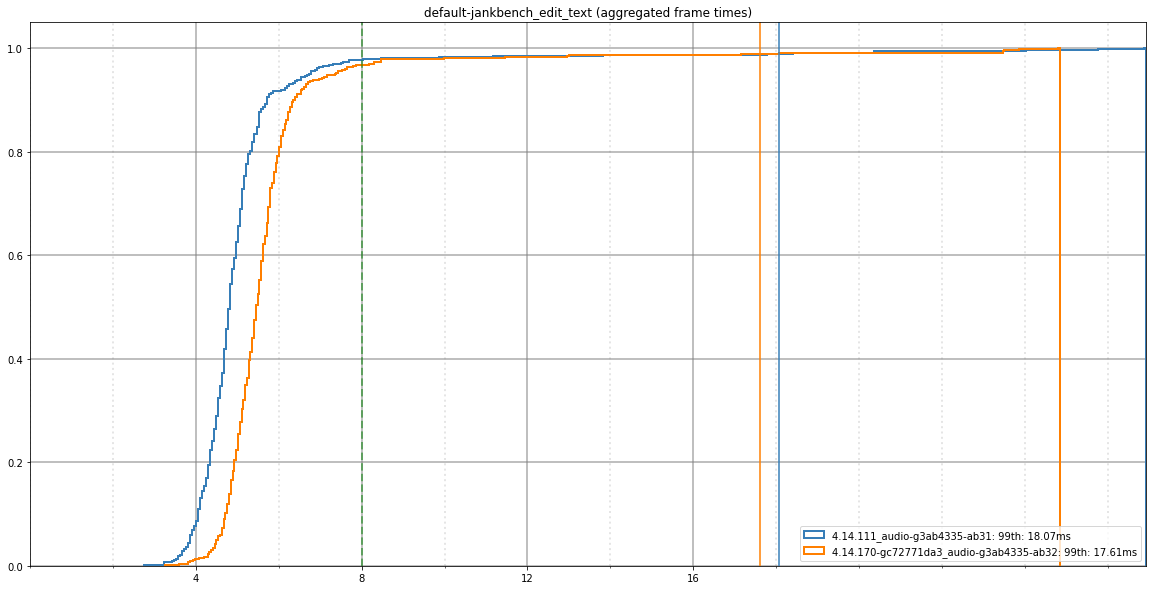

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,459.0,5.159585,4.962689,2.207224,2.755872,4.835075,18.074898,26.924210
4.14.170-gc72771da3_audio-g3ab4335-ab32,455.0,5.788414,5.610466,2.107726,3.243944,5.483238,17.608676,24.845349


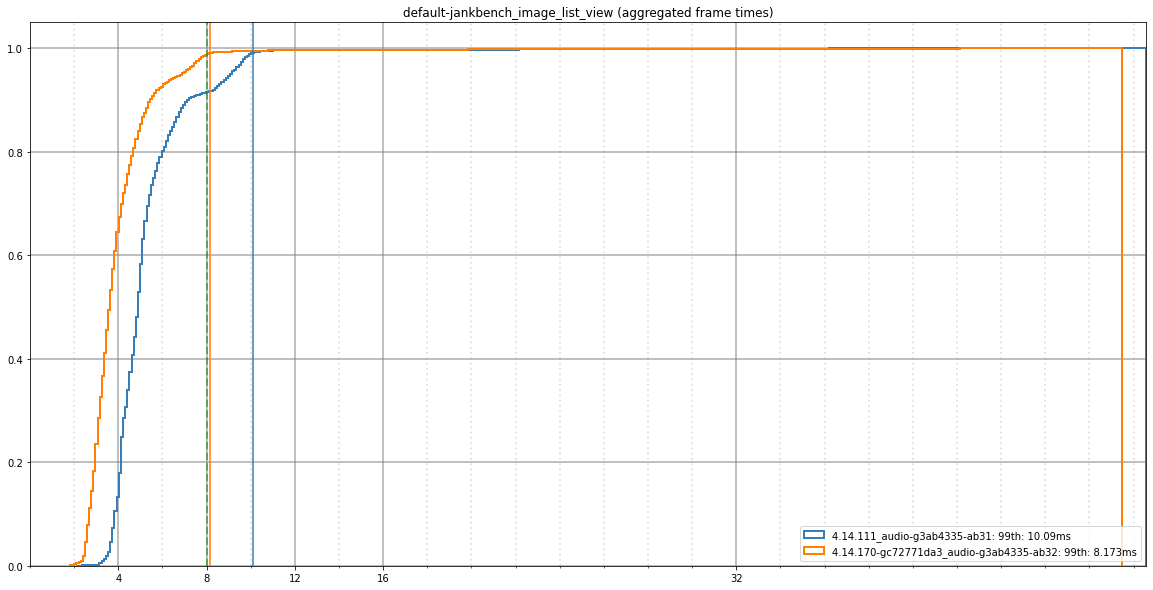

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4662.0,5.349092,5.123844,2.109163,2.076190,4.925880,10.093450,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,4660.0,4.034273,3.809810,2.061180,1.816144,3.642991,8.172914,49.497869


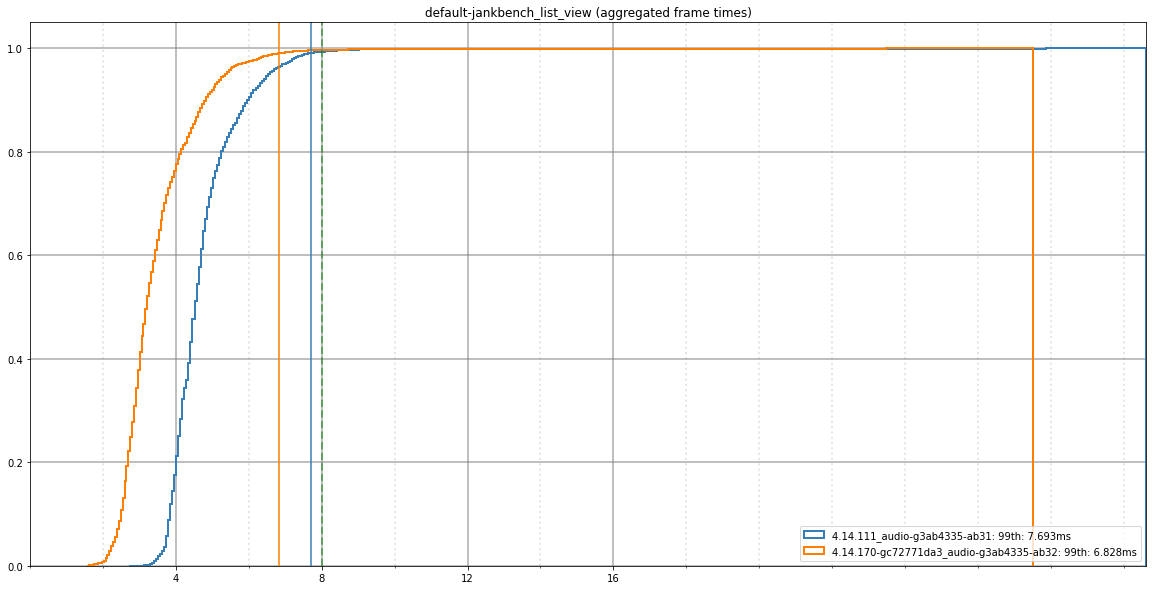

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4618.0,4.776866,4.685203,1.203624,2.726122,4.540234,7.692553,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,4618.0,3.508115,3.369581,1.245403,1.552157,3.220237,6.828499,27.517423


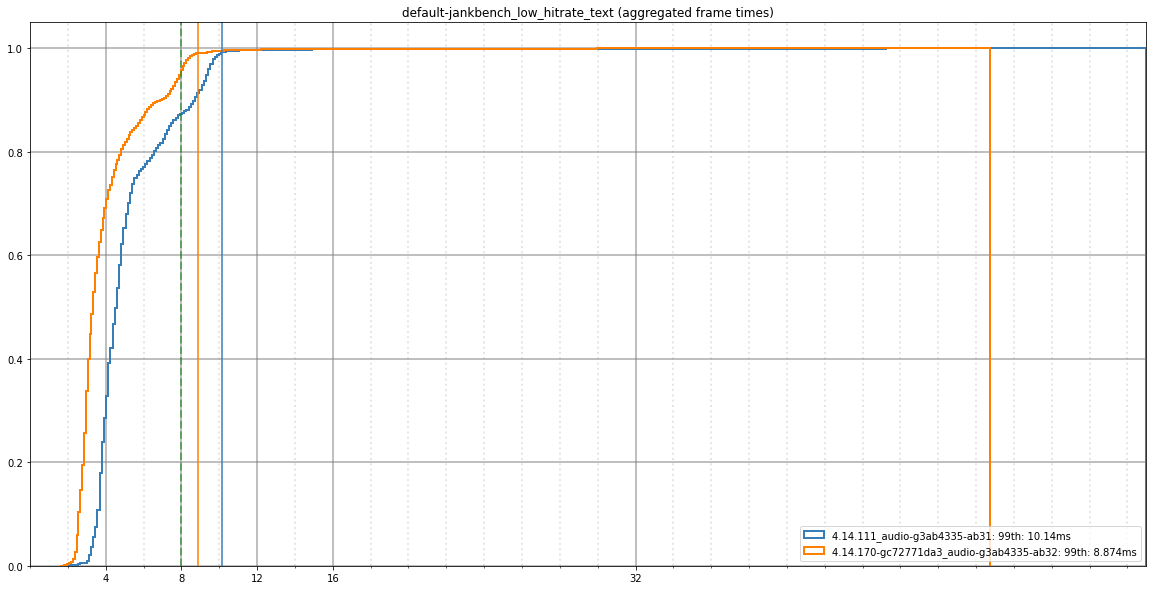

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4619.0,5.308539,4.981320,2.586923,1.609865,4.605182,10.141739,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,4619.0,4.050482,3.755365,2.071886,1.570313,3.374441,8.874638,50.738612


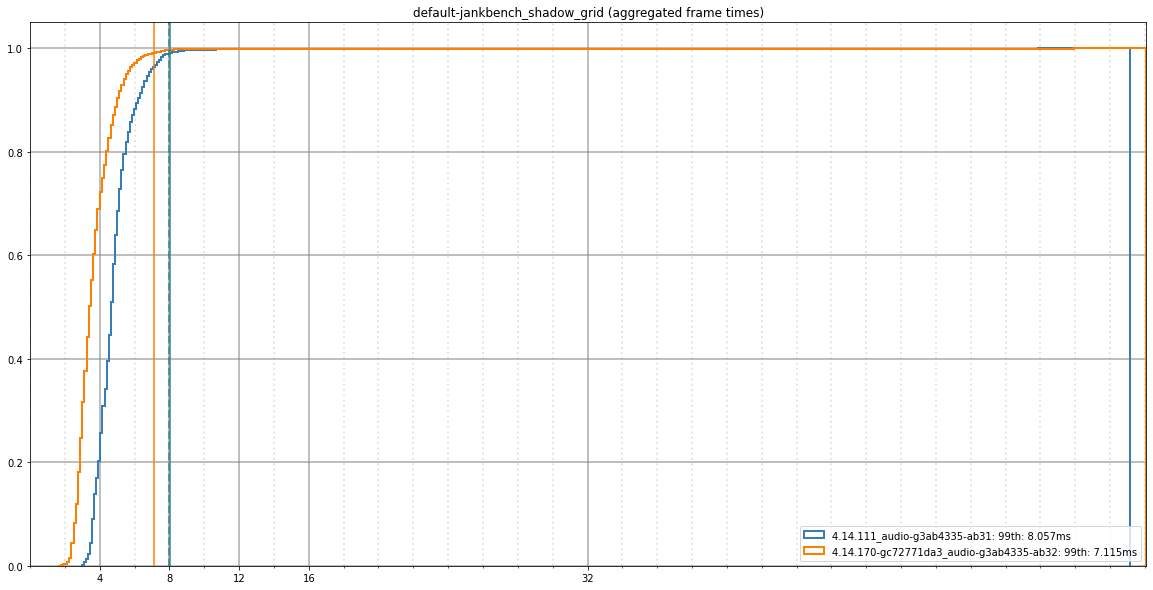

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4622.0,4.935257,4.781114,2.230878,2.952212,4.741876,8.056605,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,4622.0,3.799410,3.618140,2.302113,1.621600,3.492878,7.114644,64.061386


In [12]:

# show an aggregated CDF for each comparable pair, by workload
for workload_name in raw_df['id'].unique():
    _jankbench_plot_cdf(raw_df[raw_df['id'] == workload_name], threshold)    

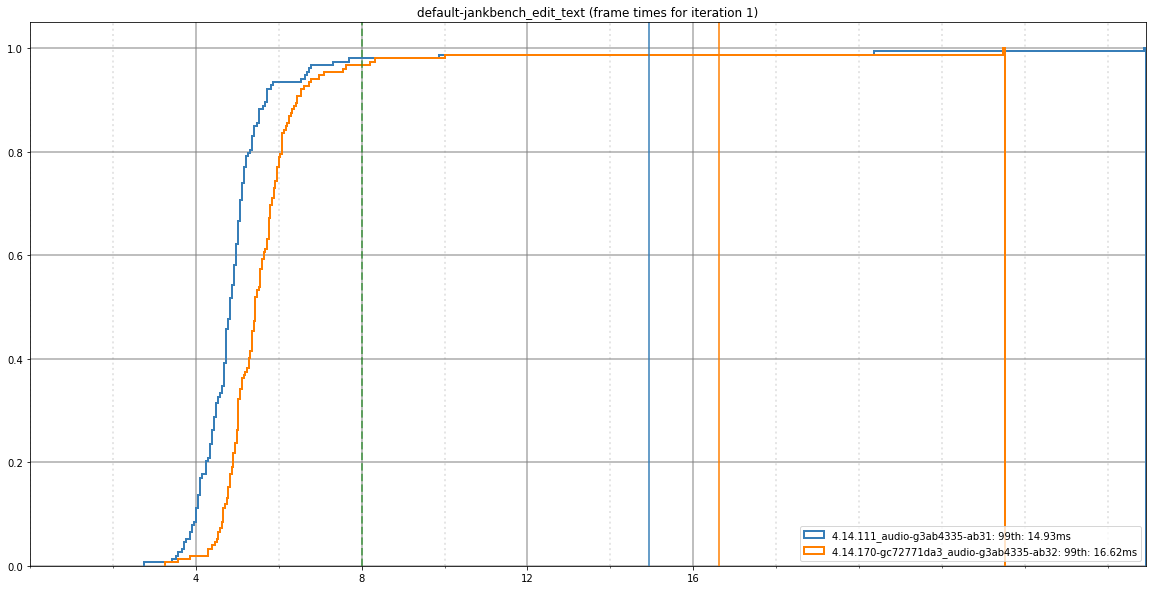

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.134157,4.928908,2.318813,2.755872,4.859580,14.930891,26.92421
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.768178,5.578591,2.218472,3.243944,5.449934,16.619324,23.51124


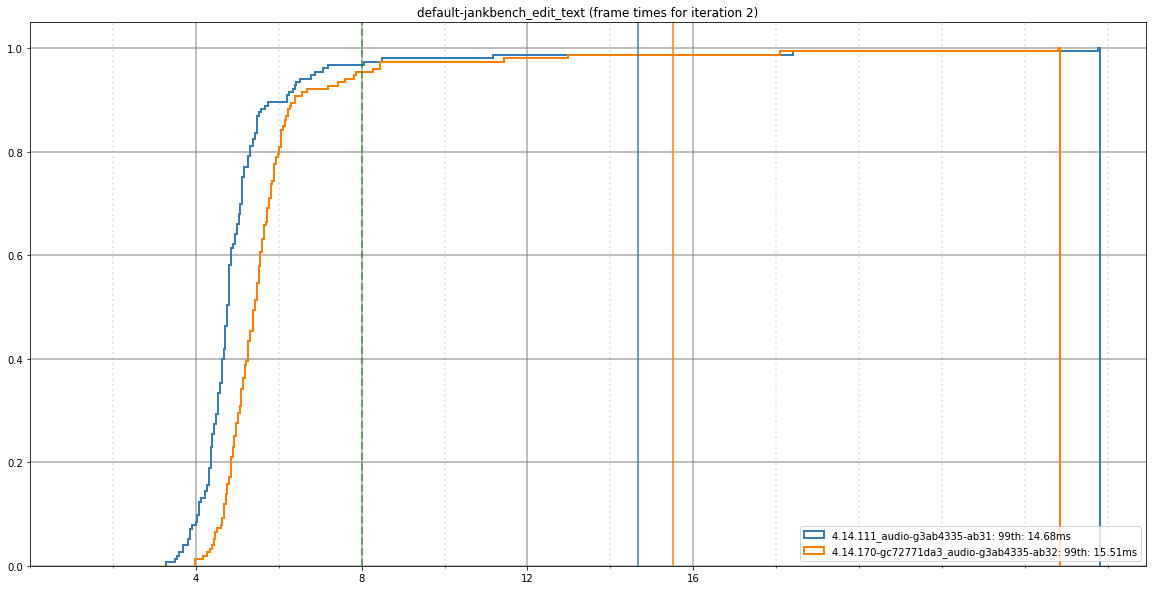

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.156334,4.955793,2.212472,3.271983,4.803898,14.676673,25.802094
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.793222,5.599173,2.162354,3.968555,5.444025,15.511048,24.845349


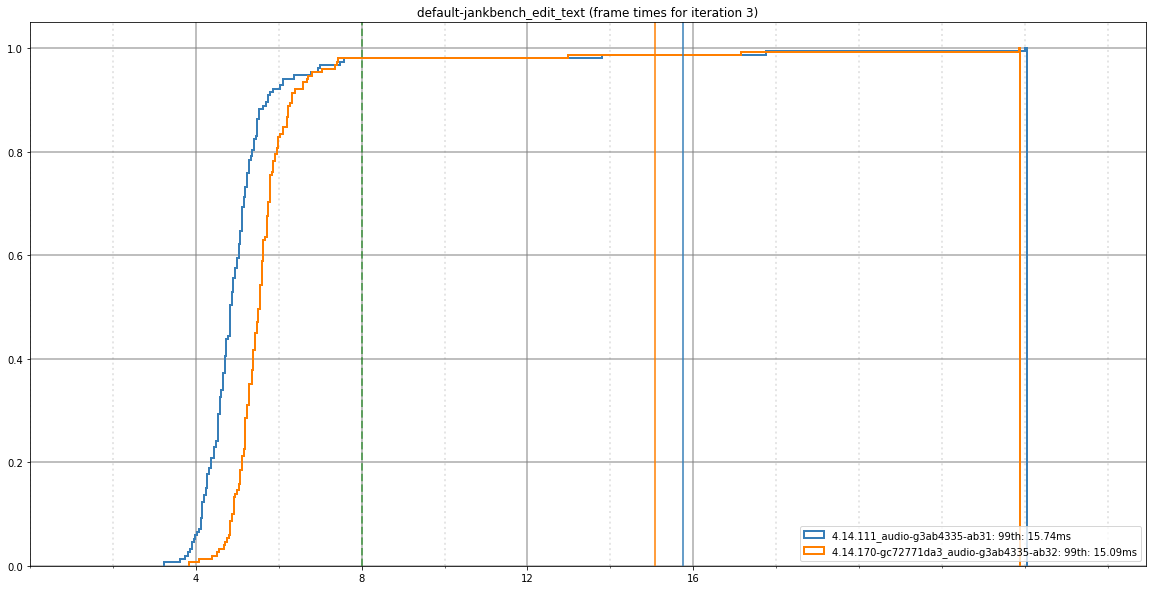

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.188264,5.003652,2.099094,3.239282,4.861180,15.742132,24.047949
4.14.170-gc72771da3_audio-g3ab4335-ab32,151.0,5.803944,5.654193,1.945235,3.824732,5.553381,15.085655,23.893524


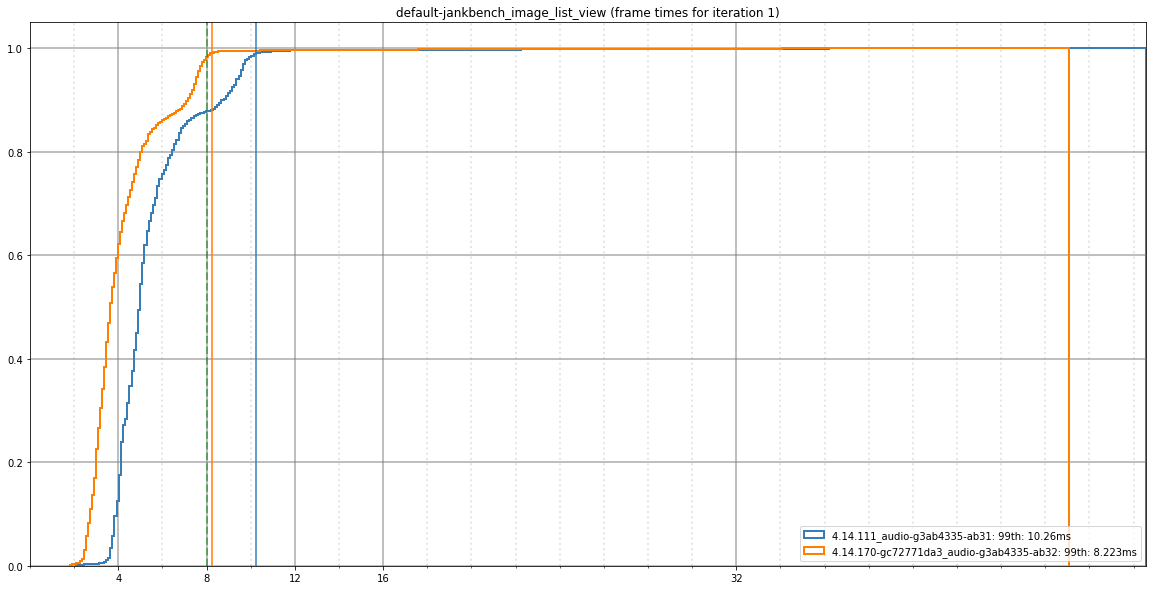

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1555.0,5.581046,5.300262,2.399445,2.076190,4.995110,10.259194,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,1552.0,4.280599,4.000879,2.127674,1.816144,3.699057,8.223343,47.088344


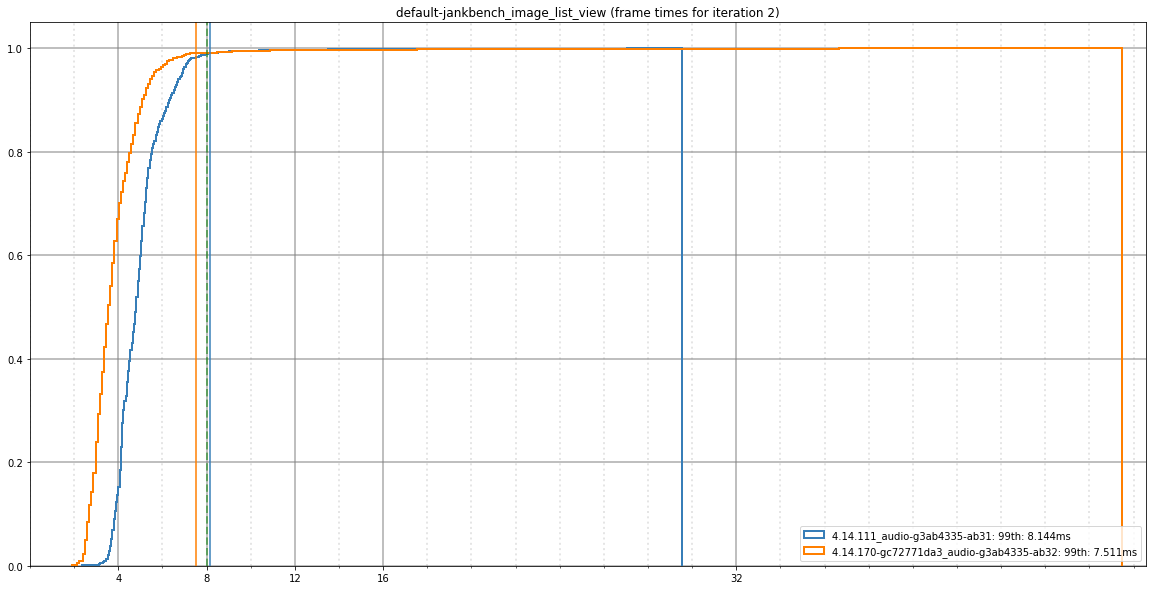

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1553.0,4.990405,4.869440,1.436331,2.369156,4.830083,8.143612,29.542067
4.14.170-gc72771da3_audio-g3ab4335-ab32,1553.0,3.911107,3.726691,1.951545,1.921995,3.619920,7.515231,49.497869


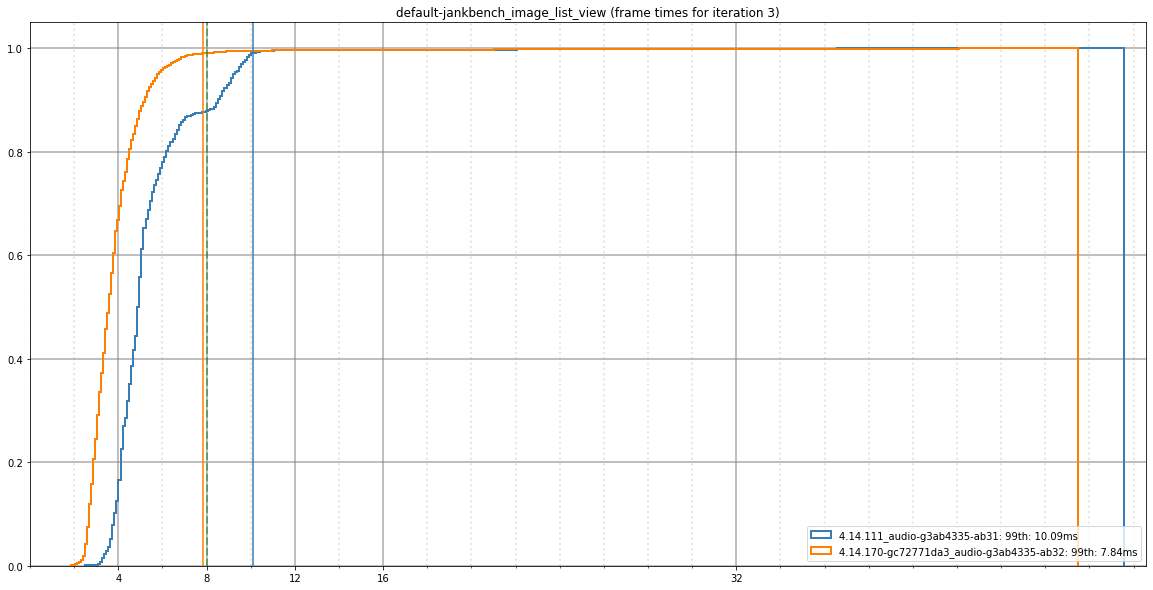

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1554.0,5.475445,5.211800,2.308716,2.500439,4.947966,10.093633,49.573037
4.14.170-gc72771da3_audio-g3ab4335-ab32,1554.0,3.911859,3.709346,2.080130,1.837316,3.602775,7.839526,47.473347


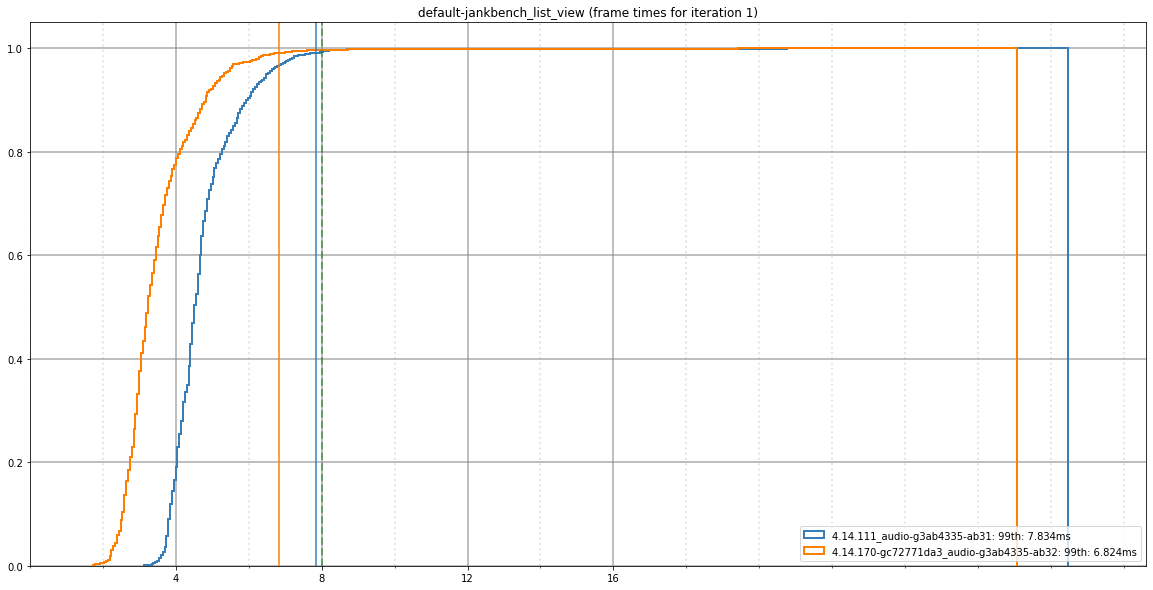

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,4.766864,4.680550,1.137408,3.130590,4.540704,7.833822,28.464746
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,3.528210,3.398287,1.211878,1.723055,3.264000,6.827057,27.068337


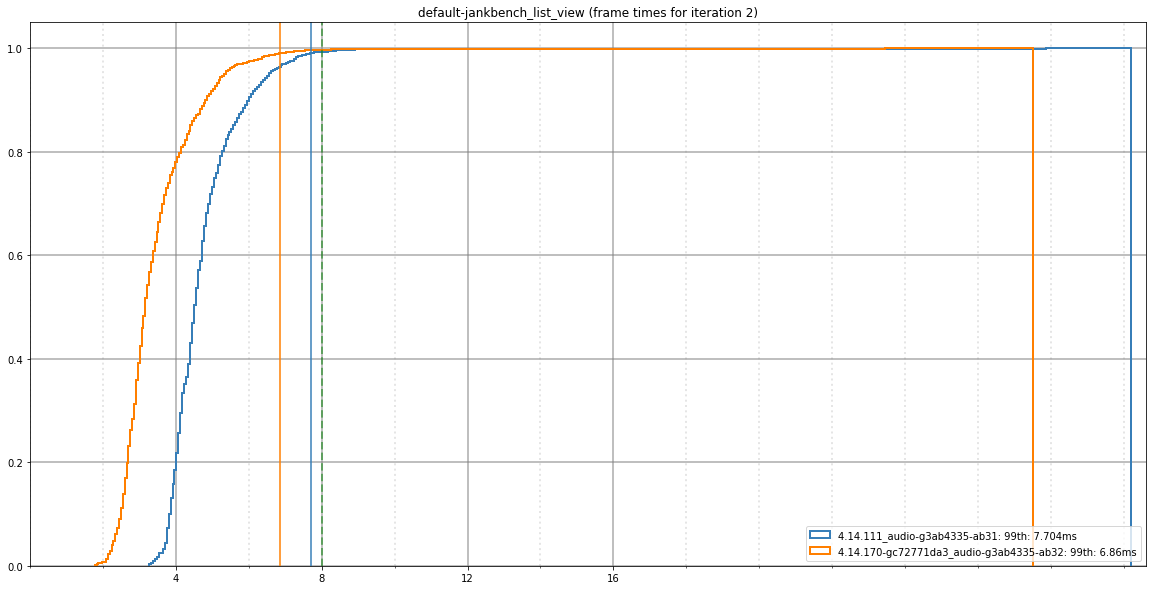

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.777654,4.682792,1.252175,3.261066,4.543900,7.704324,30.189177
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.486004,3.346952,1.269568,1.771138,3.179586,6.860087,27.517423


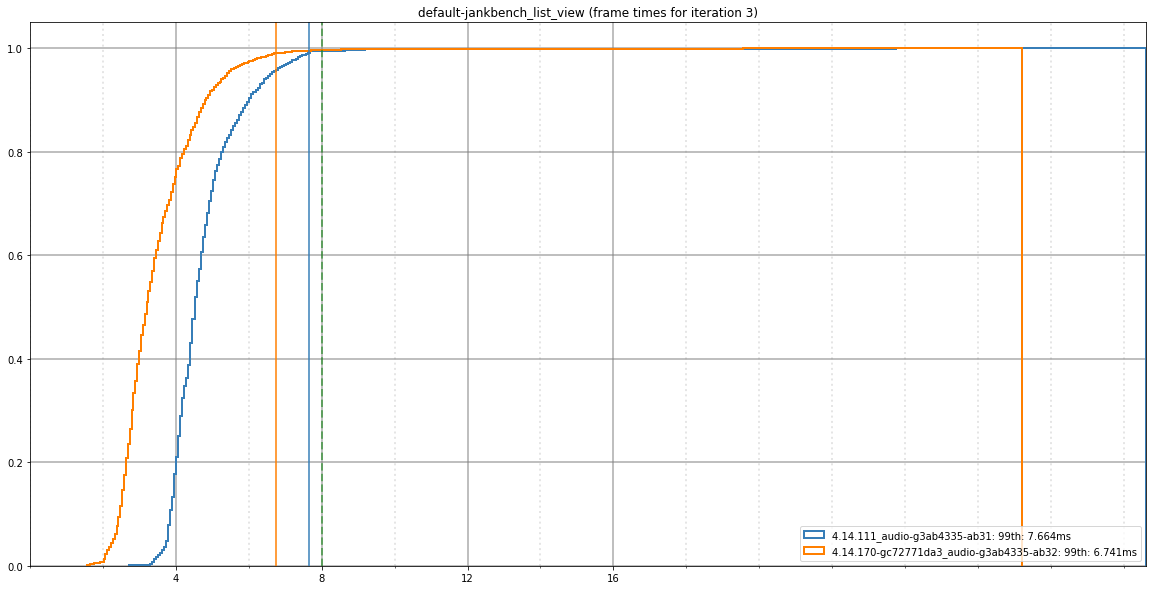

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1538.0,4.786084,4.692283,1.219042,2.726122,4.533288,7.663761,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,1538.0,3.510417,3.363903,1.254846,1.552157,3.221763,6.742260,27.213414


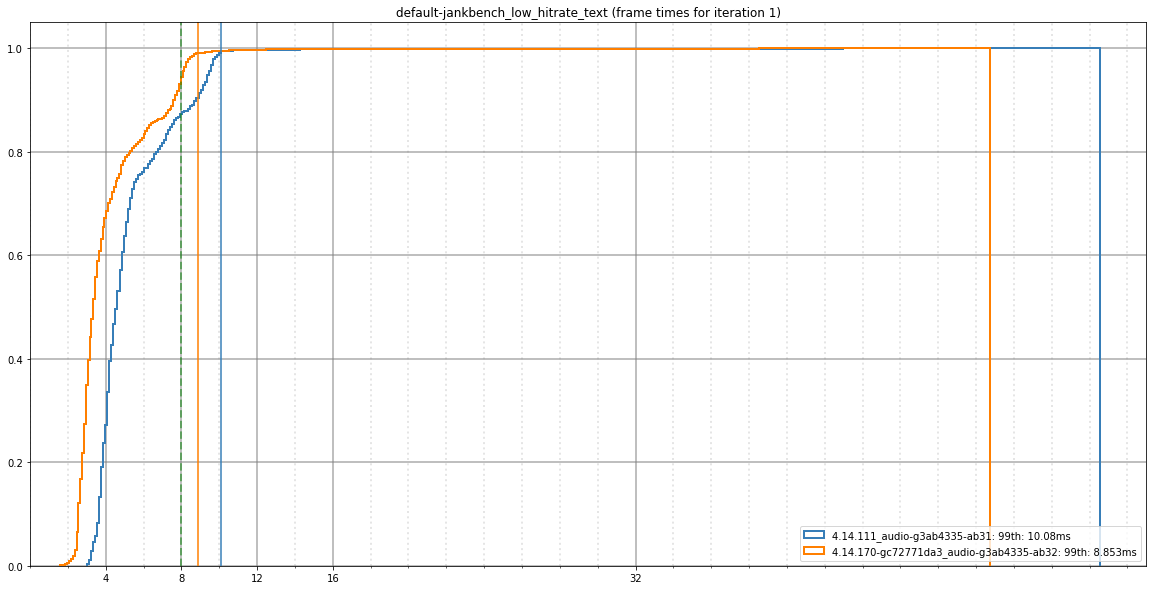

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.364815,5.045165,2.555254,3.014026,4.649350,10.082872,56.552763
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,4.202029,3.838683,2.414647,1.570313,3.403303,8.853334,50.738612


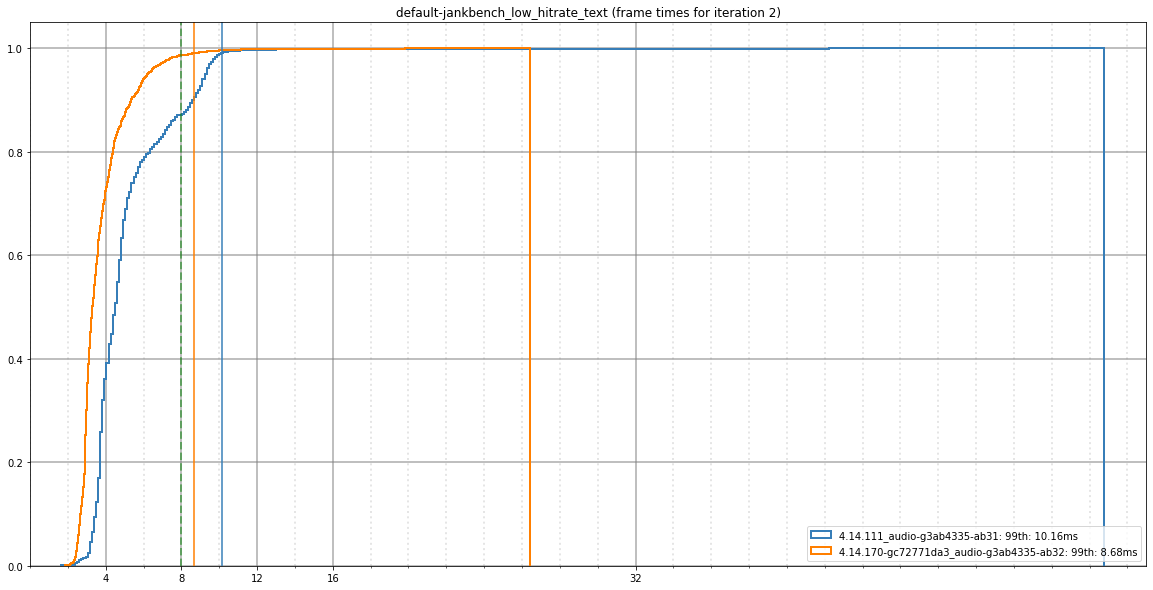

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.200935,4.863643,2.579922,1.609865,4.540425,10.156732,56.767492
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.765779,3.592029,1.435054,1.844110,3.313656,8.681754,26.435153


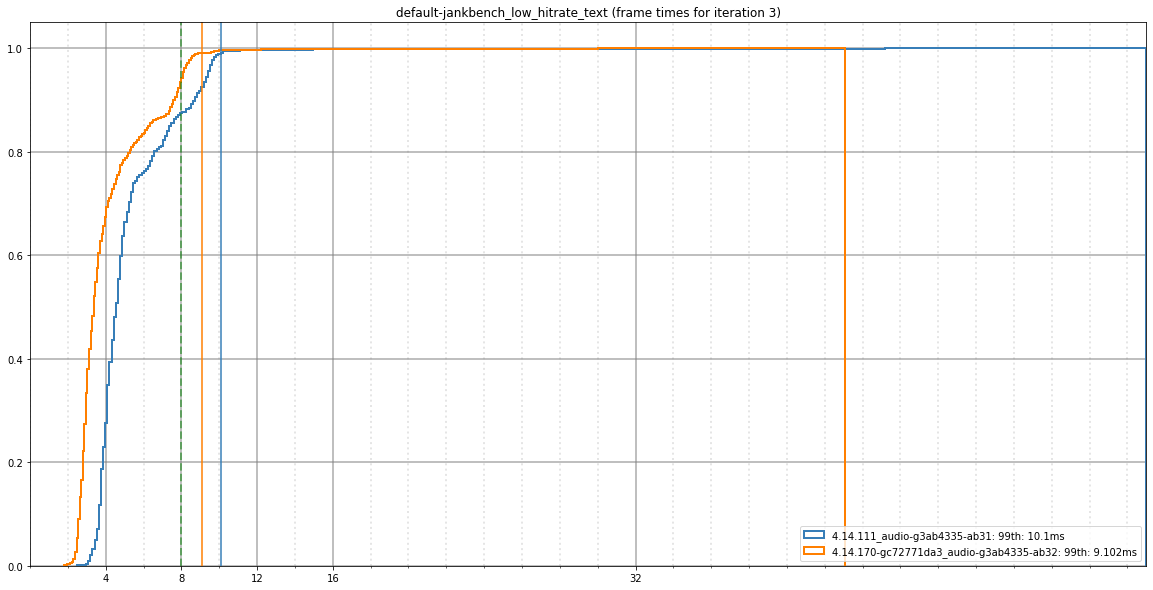

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,5.359900,5.037319,2.623473,2.502910,4.628194,10.098629,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,4.183785,3.841043,2.207310,1.793326,3.400450,9.104537,43.093869


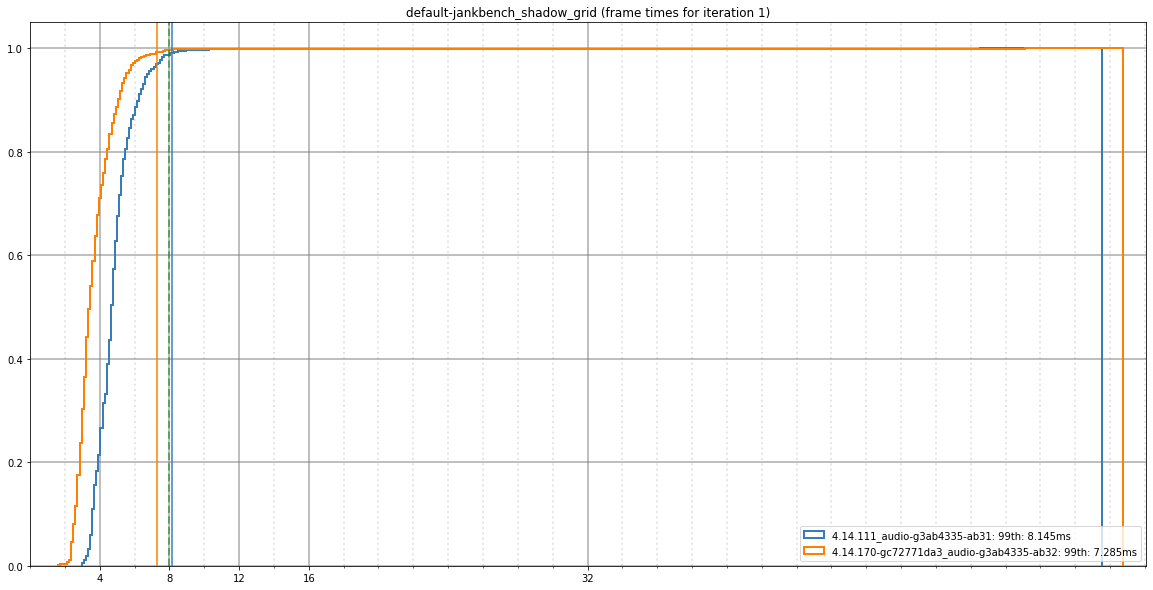

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,4.931087,4.774545,2.194790,2.987405,4.739452,8.145406,61.546247
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.793683,3.610495,2.276881,1.621600,3.466817,7.285168,62.746171


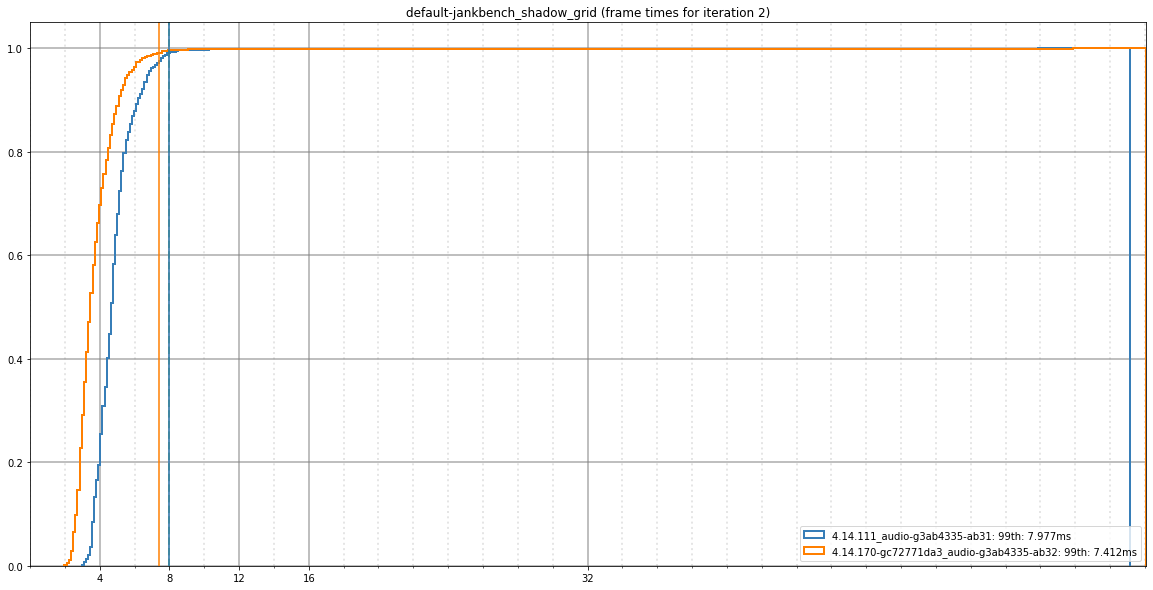

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.940513,4.786793,2.255955,2.952212,4.745021,7.977249,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.844818,3.659118,2.342929,1.974045,3.511382,7.412238,64.061386


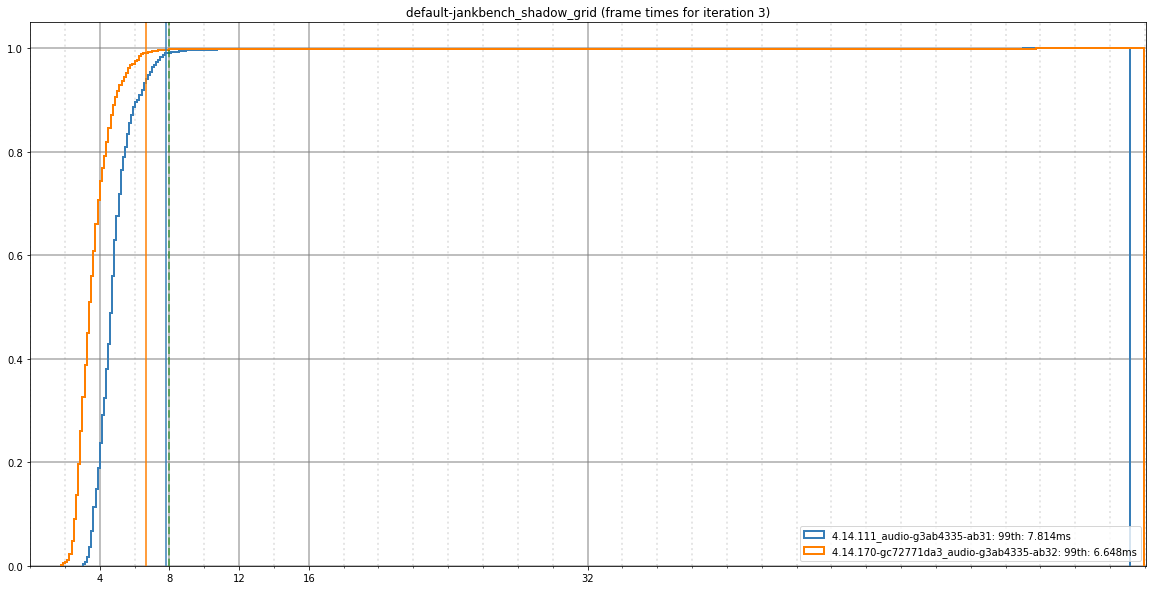

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.934167,4.782006,2.242838,3.035733,4.736753,7.814312,63.113073
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.759559,3.585003,2.286703,1.764562,3.497899,6.647733,63.970617


In [13]:
# show a CDF for each run of a workload
for workload_name in raw_df['id'].unique():
    iterations = sorted(raw_df[raw_df['id'] == workload_name]['iteration'].unique())
    for i in iterations:
        _jankbench_plot_cdf(raw_df[raw_df['id'] == workload_name], threshold, aggregate_iterations=False, iteration = i)

## Plot frame times in order (one iteration at a time)

In [14]:
# df - results from the collector, filtered to only one test
# time - threshold time to draw on the plot

def __jankbench_draw_times(ax, df):
    display_df = pd.DataFrame()
    for kernel in df['kernel'].unique():
        tmp_df = df[df['kernel'] == kernel]
        nn_q = df[df['kernel'] == kernel]['total_duration'].quantile(0.99)
        tmp_df.plot(x='frame_id', y='total_duration', ax=ax, label="{}: 99th: {:2.4}ms".format(kernel ,nn_q))
        color = ax.lines[-1].get_color()
        ax.axhline(nn_q, color=color)
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    ax.legend(loc='upper right')
    return display_df
    
def _jankbench_plot_frametimes(df, time, iteration=1, ax=None):
    # encapsulate fig
    def __display_fig(fig):
        if fig is not None:
            display(fig)
    # calculate a Geomean line for describe output
    def __summarize(describe_df):
        # display description including geomean
        summary_df = describe_df.describe(percentiles=[0.5, 0.99]).transpose()
        summary_df.insert(2, 'geomean', value=0.0, allow_duplicates=True)
        for kernel in describe_df:
            summary_df.at[kernel, 'geomean'] = stats.gmean(describe_df[kernel].dropna(), axis=0)
        return summary_df
            
    if ax is None:
        # set up figure
        fig = plt.figure(figsize=(20,10))
        ax = plt.axes()
    else:
        fig = None

    # Ensure we draw same width for all lines
    longest_frame = df['total_duration'].max()
    # set up grid
    major_ticks = [ 4.0, 8.0, 12.0, 16.0, 32.0 ]
    minor_ticks = np.arange(0, longest_frame, 2)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2, color='grey', linestyle='dotted', linewidth=2)
    ax.grid(which='major', alpha=0.5, color='grey', linestyle='-', linewidth=2)
    ax.axhline(time, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    ax.set_ylim((0.0, longest_frame))
    # draw frame render times
    ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))      
    describe_df = __jankbench_draw_times(ax, df[df['iteration'] == iteration])
    __display_fig(fig)
    display(__summarize(describe_df))

    if fig is not None:
        plt.close(fig)


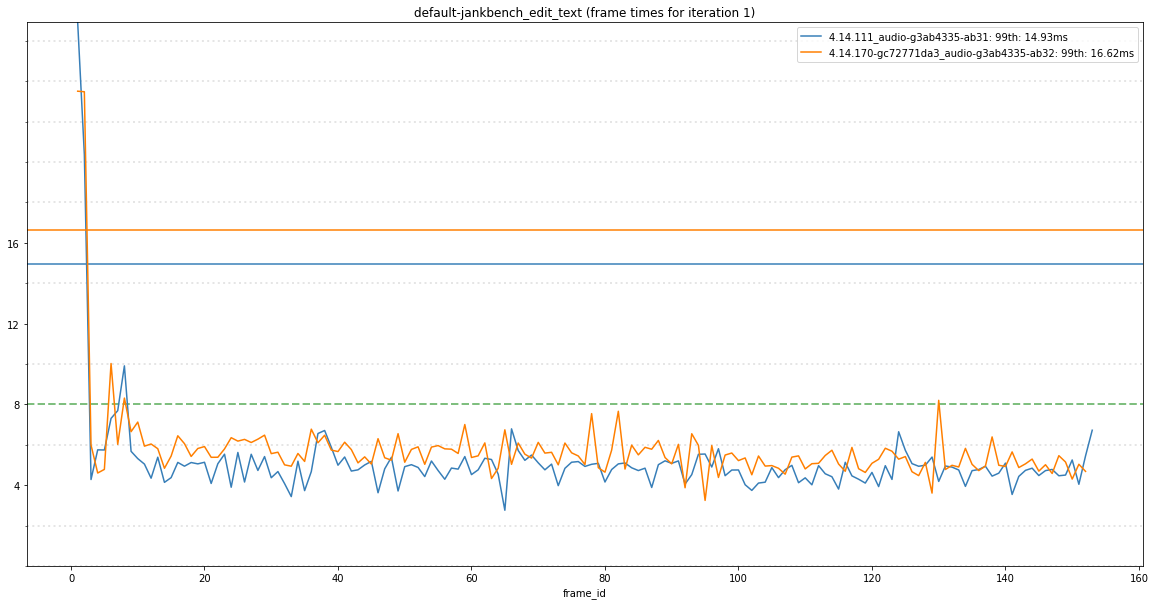

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.134157,4.928908,2.318813,2.755872,4.859580,14.930891,26.92421
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.768178,5.578591,2.218472,3.243944,5.449934,16.619324,23.51124


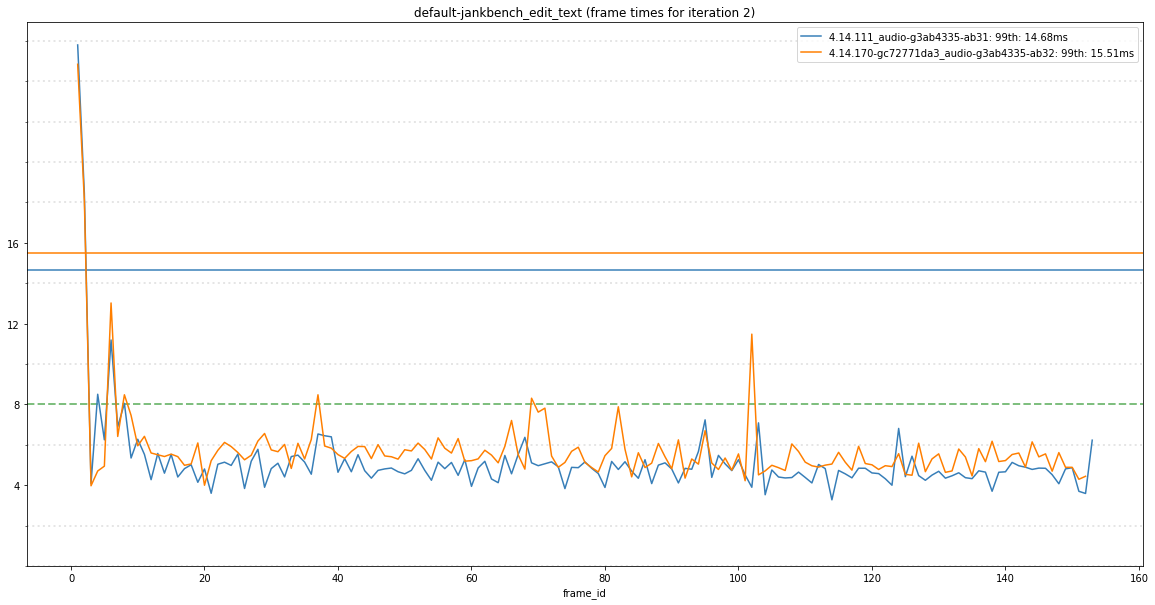

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.156334,4.955793,2.212472,3.271983,4.803898,14.676673,25.802094
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.793222,5.599173,2.162354,3.968555,5.444025,15.511048,24.845349


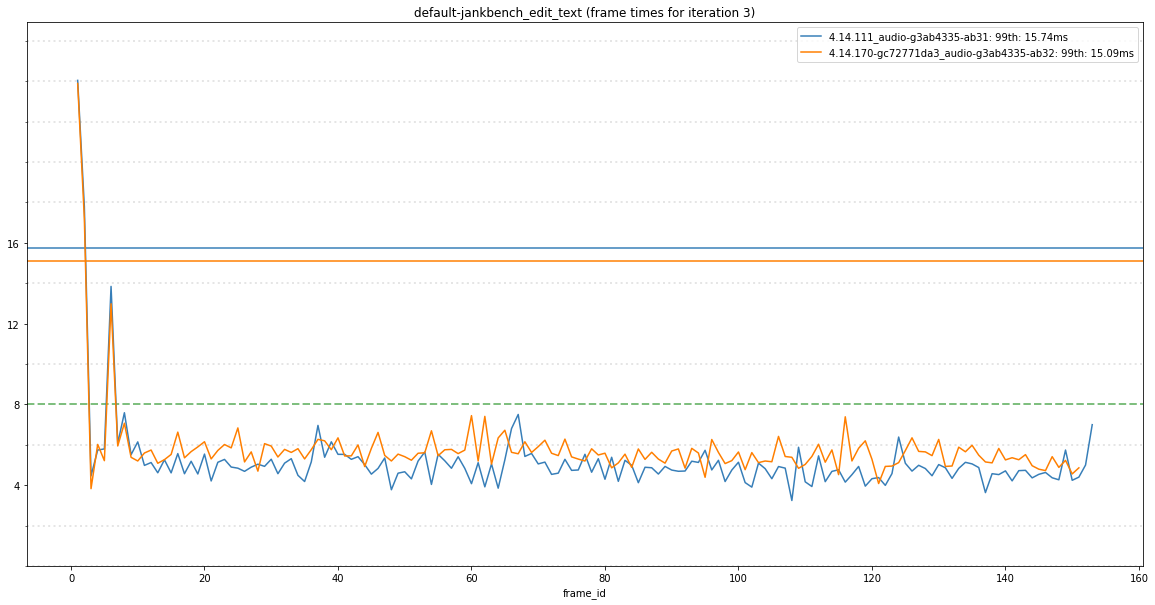

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.188264,5.003652,2.099094,3.239282,4.861180,15.742132,24.047949
4.14.170-gc72771da3_audio-g3ab4335-ab32,151.0,5.803944,5.654193,1.945235,3.824732,5.553381,15.085655,23.893524


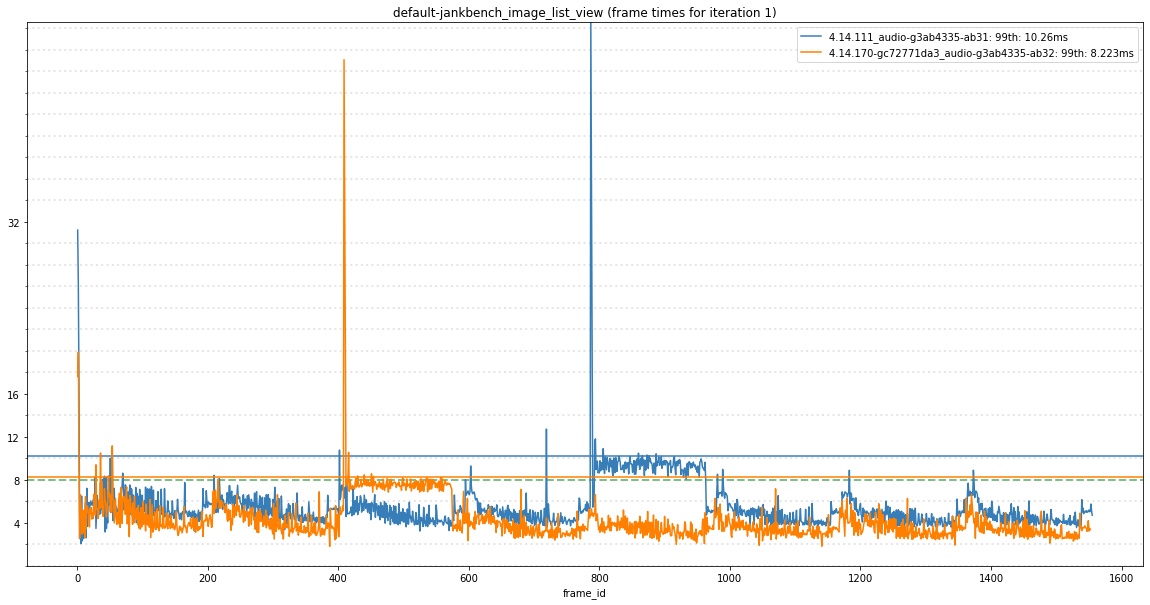

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1555.0,5.581046,5.300262,2.399445,2.076190,4.995110,10.259194,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,1552.0,4.280599,4.000879,2.127674,1.816144,3.699057,8.223343,47.088344


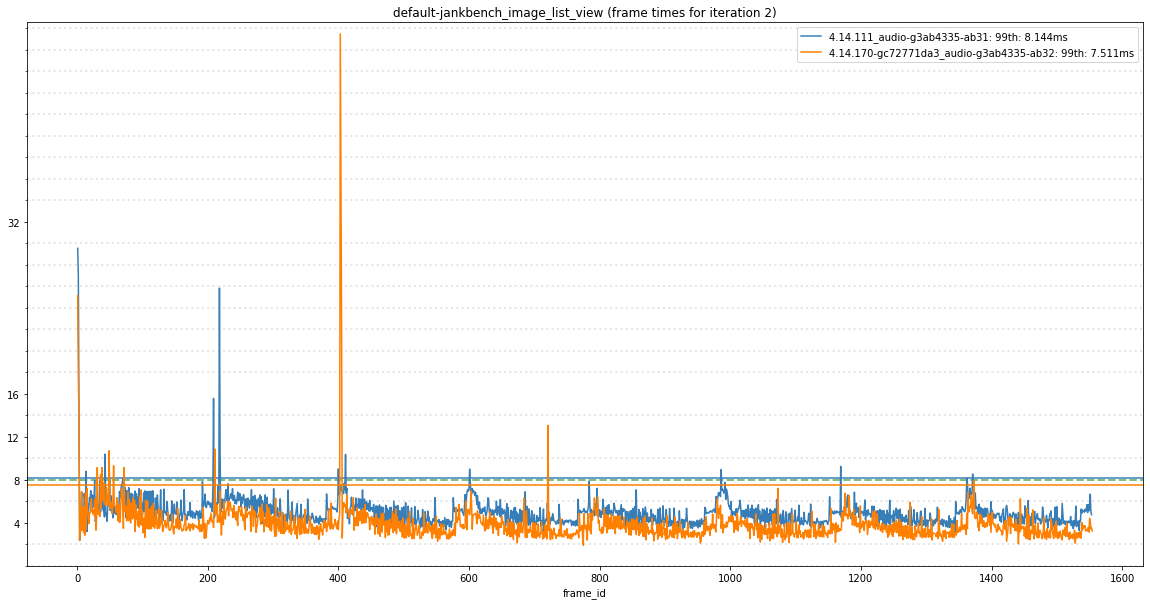

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1553.0,4.990405,4.869440,1.436331,2.369156,4.830083,8.143612,29.542067
4.14.170-gc72771da3_audio-g3ab4335-ab32,1553.0,3.911107,3.726691,1.951545,1.921995,3.619920,7.515231,49.497869


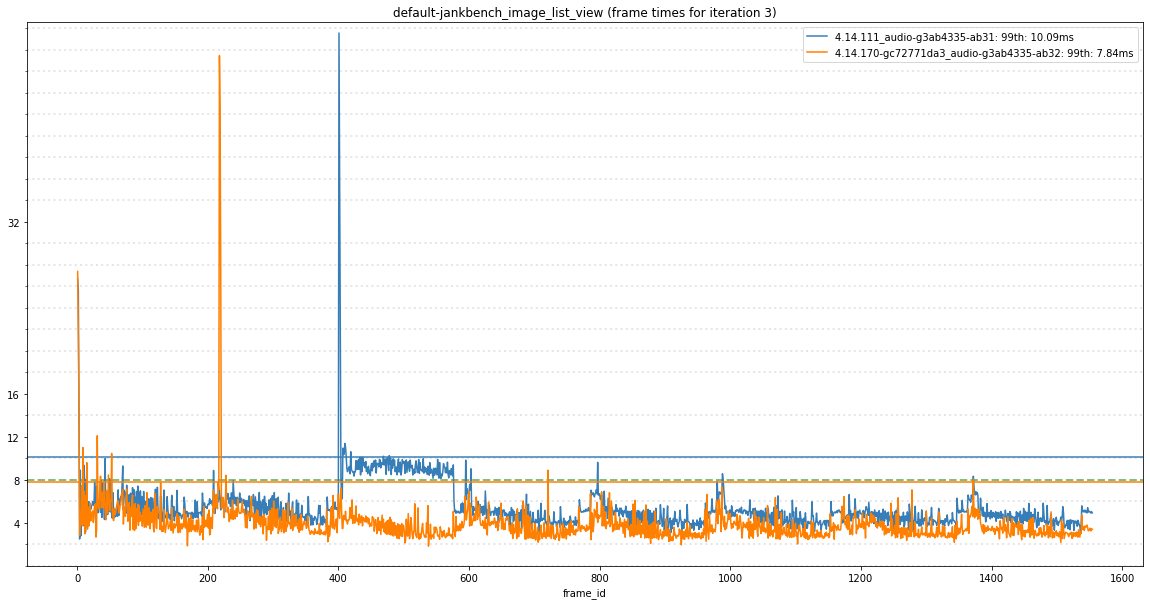

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1554.0,5.475445,5.211800,2.308716,2.500439,4.947966,10.093633,49.573037
4.14.170-gc72771da3_audio-g3ab4335-ab32,1554.0,3.911859,3.709346,2.080130,1.837316,3.602775,7.839526,47.473347


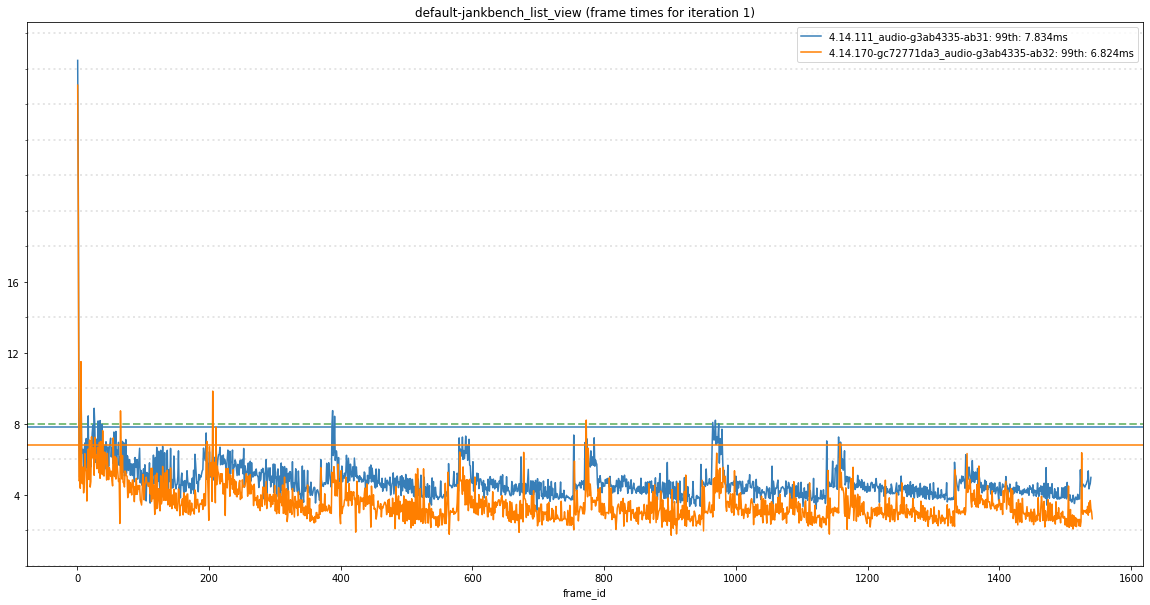

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,4.766864,4.680550,1.137408,3.130590,4.540704,7.833822,28.464746
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,3.528210,3.398287,1.211878,1.723055,3.264000,6.827057,27.068337


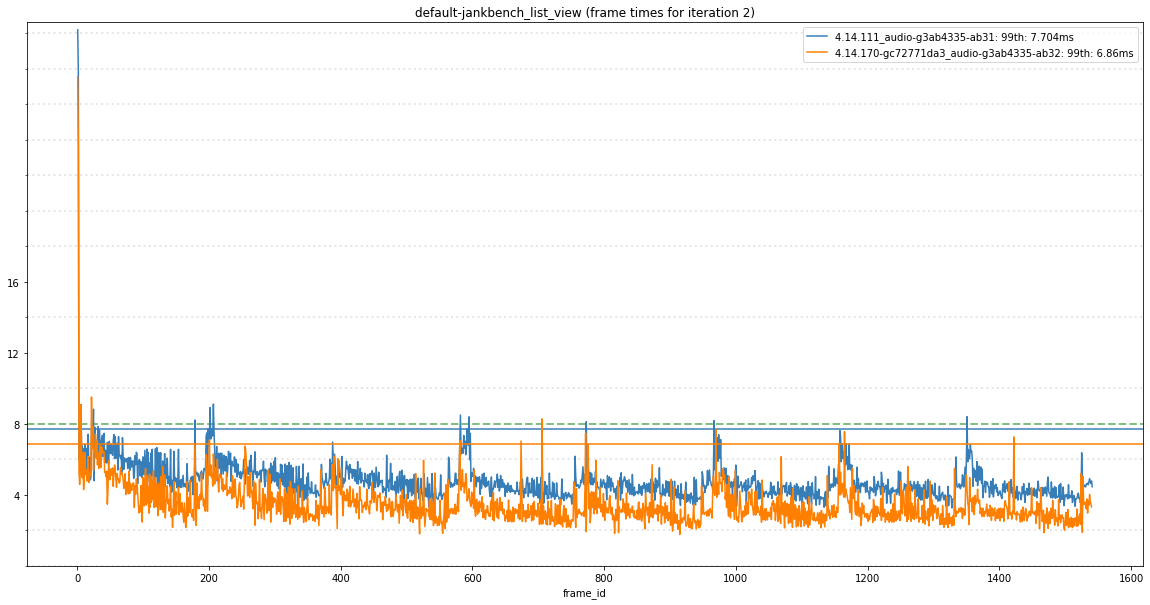

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.777654,4.682792,1.252175,3.261066,4.543900,7.704324,30.189177
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.486004,3.346952,1.269568,1.771138,3.179586,6.860087,27.517423


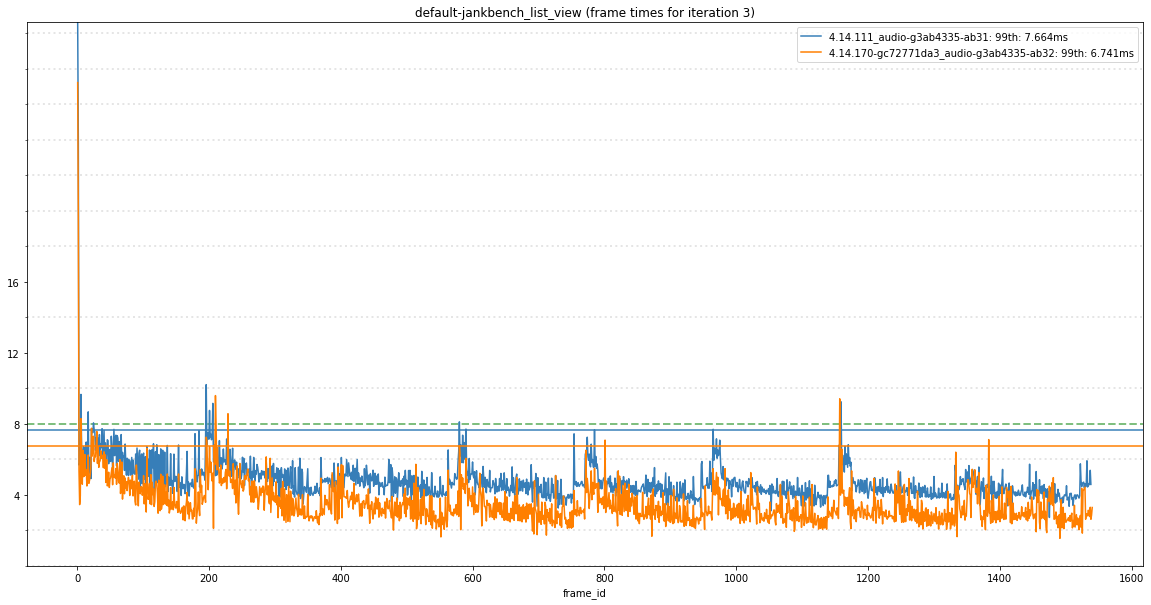

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1538.0,4.786084,4.692283,1.219042,2.726122,4.533288,7.663761,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,1538.0,3.510417,3.363903,1.254846,1.552157,3.221763,6.742260,27.213414


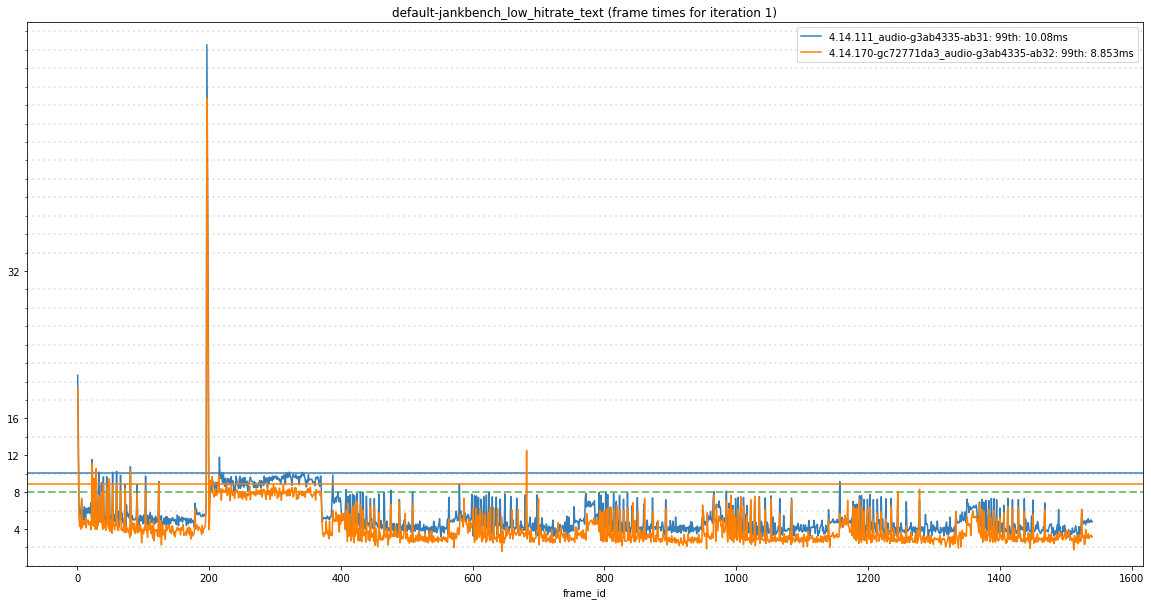

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.364815,5.045165,2.555254,3.014026,4.649350,10.082872,56.552763
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,4.202029,3.838683,2.414647,1.570313,3.403303,8.853334,50.738612


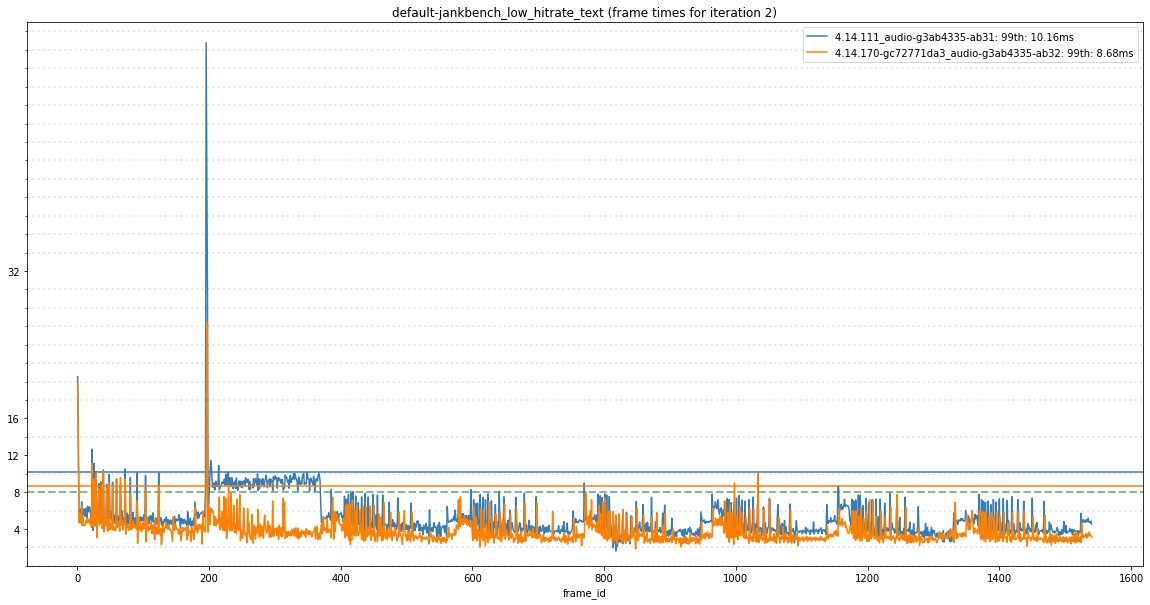

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.200935,4.863643,2.579922,1.609865,4.540425,10.156732,56.767492
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.765779,3.592029,1.435054,1.844110,3.313656,8.681754,26.435153


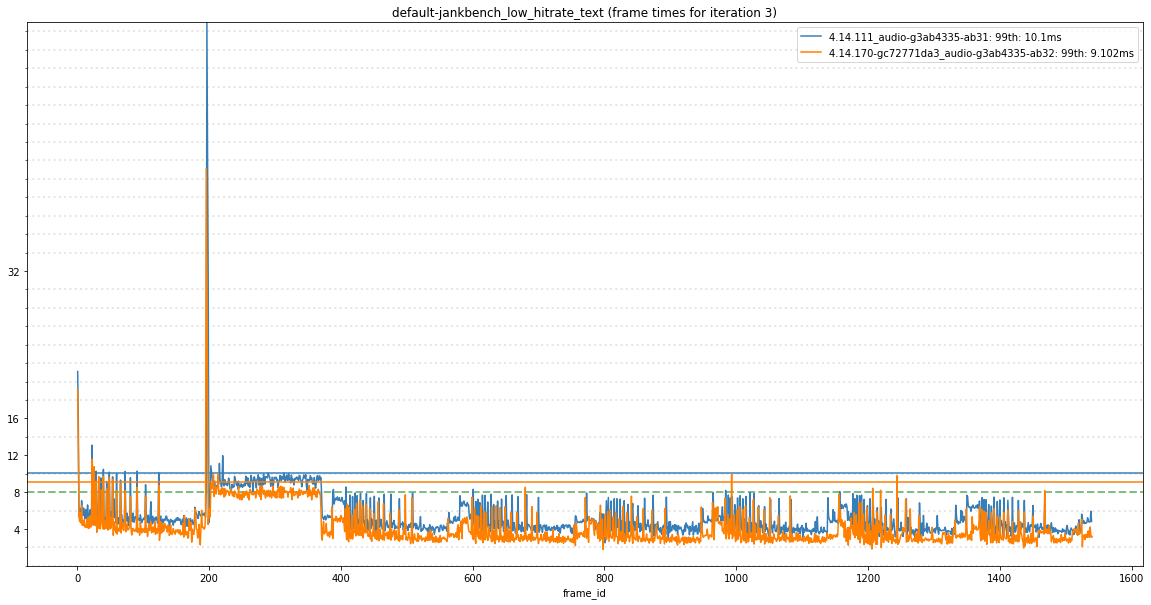

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,5.359900,5.037319,2.623473,2.502910,4.628194,10.098629,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,4.183785,3.841043,2.207310,1.793326,3.400450,9.104537,43.093869


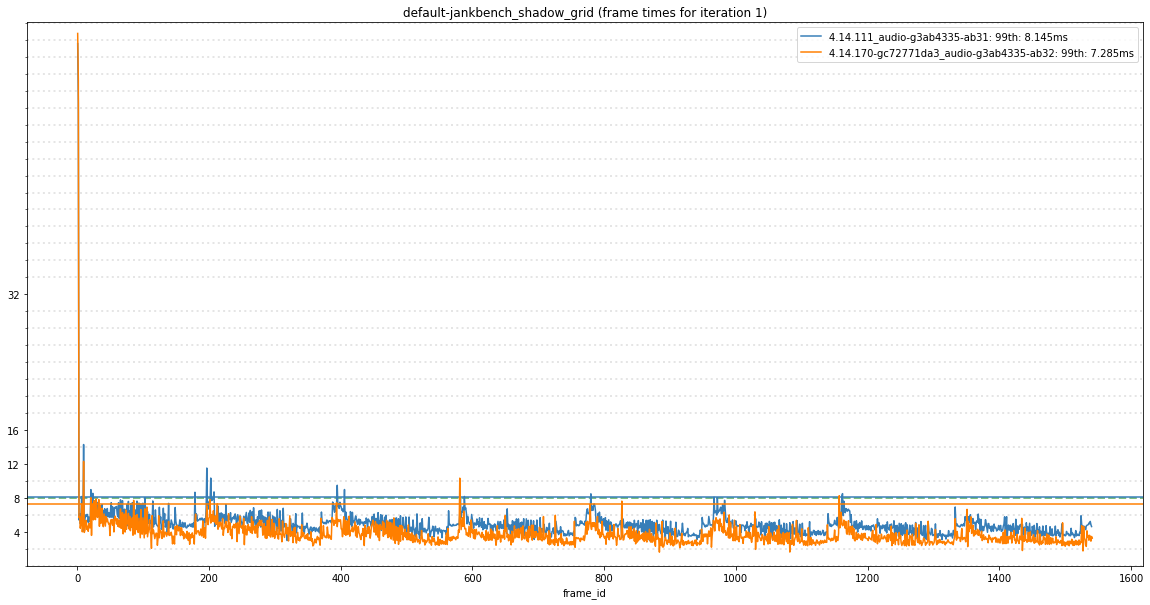

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,4.931087,4.774545,2.194790,2.987405,4.739452,8.145406,61.546247
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.793683,3.610495,2.276881,1.621600,3.466817,7.285168,62.746171


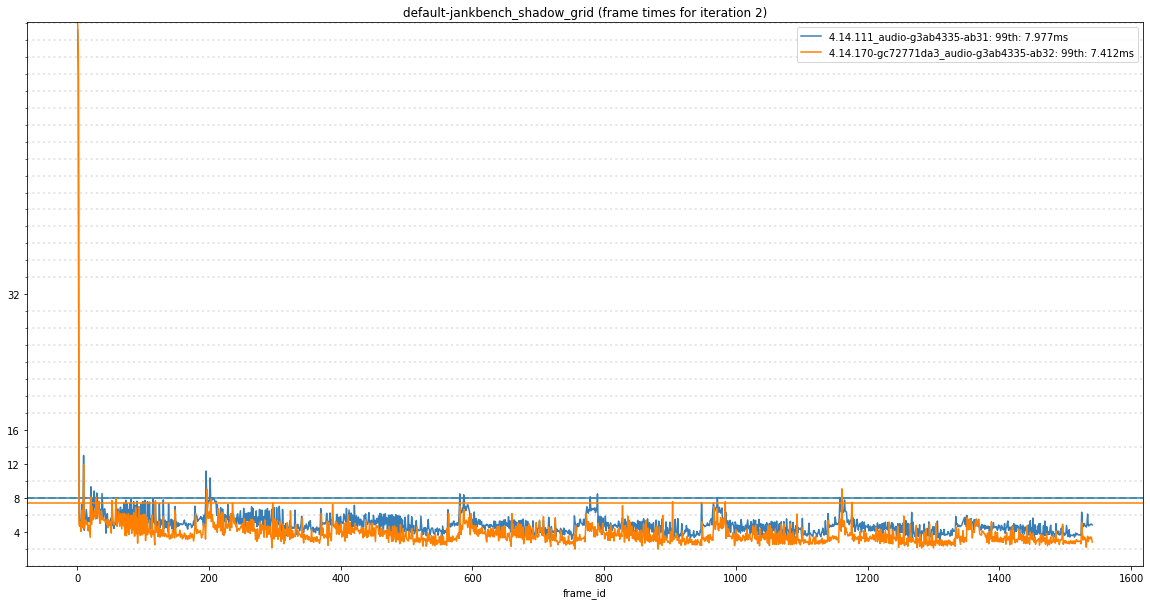

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.940513,4.786793,2.255955,2.952212,4.745021,7.977249,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.844818,3.659118,2.342929,1.974045,3.511382,7.412238,64.061386


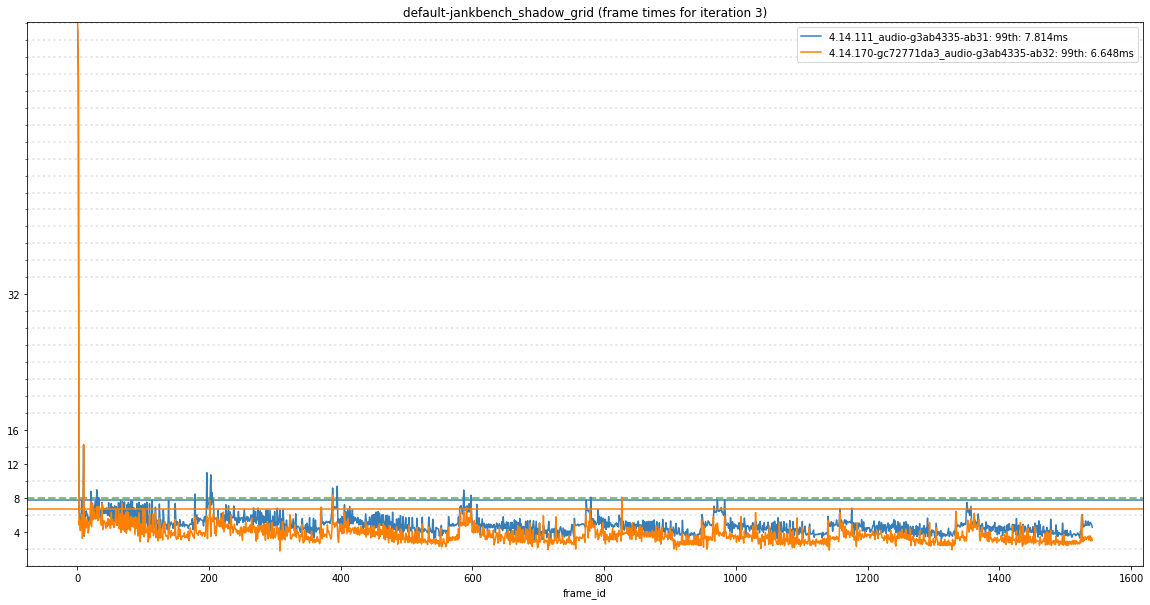

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.934167,4.782006,2.242838,3.035733,4.736753,7.814312,63.113073
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.759559,3.585003,2.286703,1.764562,3.497899,6.647733,63.970617


In [15]:
# plot a pair of frame time lines for each iteration, by workload
for workload_name in raw_df['id'].unique():
    tmp_df = raw_df[raw_df['id'] == workload_name]
    iterations = sorted(tmp_df['iteration'].unique())
    for it in iterations:
        _jankbench_plot_frametimes(raw_df[raw_df['id'] == workload_name], threshold, iteration=it)

## Box Plots of Frame Times

In [16]:
# df - results from the collector, filtered to only one test
def __jankbench_draw_boxplot(ax, df):
    display_df = pd.DataFrame()
    columns = []
    for kernel in df['kernel'].unique():
        columns.append(kernel)
        display_df[kernel] = pd.Series(df[df['kernel'] == kernel]['total_duration'].values)
    display_df.boxplot(column=columns, ax=ax, vert=False)
    return display_df
    
def _jankbench_boxplot_frametimes(df, time, iteration=None, ax=None):
    # encapsulate fig
    def __display_fig(fig):
        if fig is not None:
            display(fig)
    # calculate a Geomean line for describe output
    def __summarize(describe_df):
        # display description including geomean
        summary_df = describe_df.describe(percentiles=[0.5, 0.99]).transpose()
        summary_df.insert(2, 'geomean', value=0.0, allow_duplicates=True)
        for kernel in describe_df:
            summary_df.at[kernel, 'geomean'] = stats.gmean(describe_df[kernel].dropna(), axis=0)
        return summary_df
    if ax is None:
        # set up figure
        fig = plt.figure(figsize=(20,10))
        ax = plt.axes()
    else:
        fig = None
    # draw boxplots
    if iteration is not None:
        ax.set_title("{} (frame times for iteration {})".format(df['id'].unique()[0], iteration))      
        describe_df = __jankbench_draw_boxplot(ax, df[df['iteration'] == iteration])
    else:
        ax.set_title("{} (frame times for all iterations)".format(df['id'].unique()[0]))      
        describe_df = __jankbench_draw_boxplot(ax, df)
    ax.axvline(time, alpha=0.5, color='green', linestyle='dashed', linewidth=2)
    __display_fig(fig)
    display(__summarize(describe_df))

    if fig is not None:
        plt.close(fig)


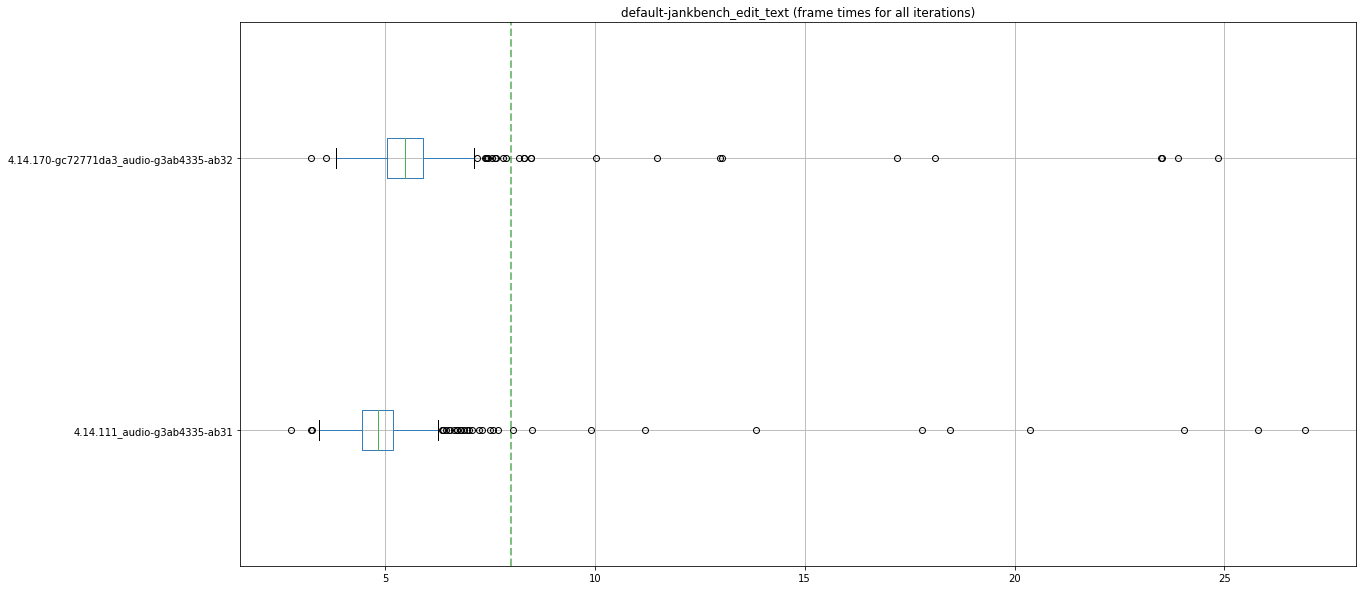

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,459.0,5.159585,4.962689,2.207224,2.755872,4.835075,18.074898,26.924210
4.14.170-gc72771da3_audio-g3ab4335-ab32,455.0,5.788414,5.610466,2.107726,3.243944,5.483238,17.608676,24.845349


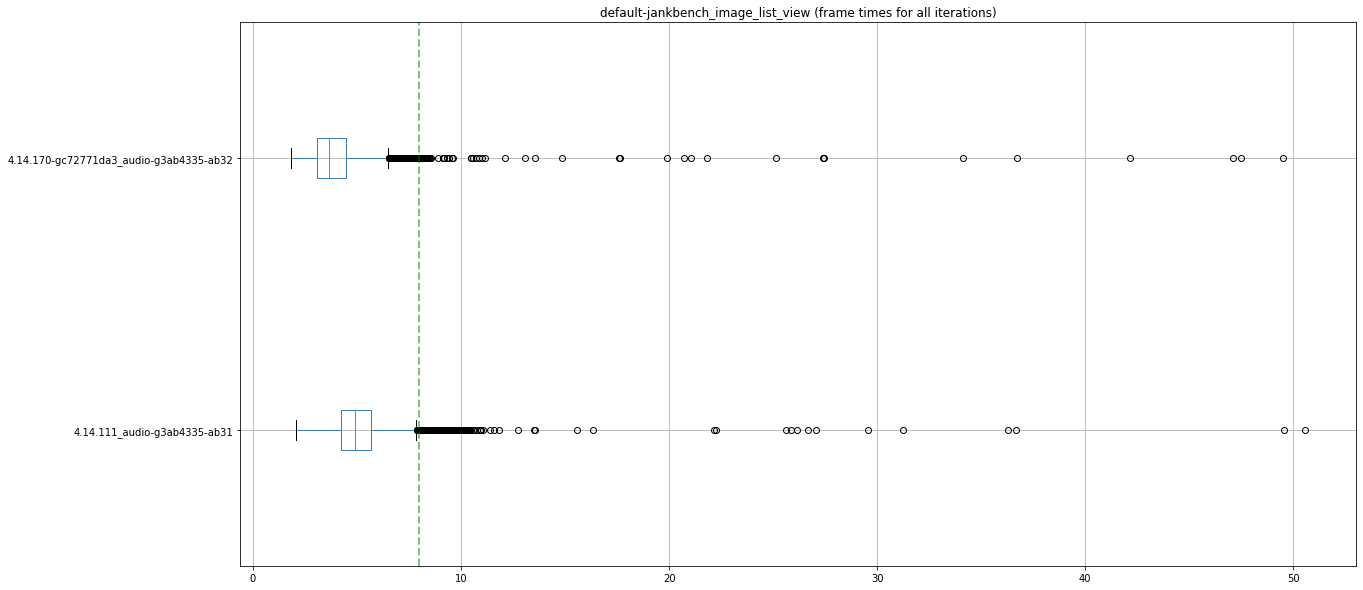

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4662.0,5.349092,5.123844,2.109163,2.076190,4.925880,10.093450,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,4660.0,4.034273,3.809810,2.061180,1.816144,3.642991,8.172914,49.497869


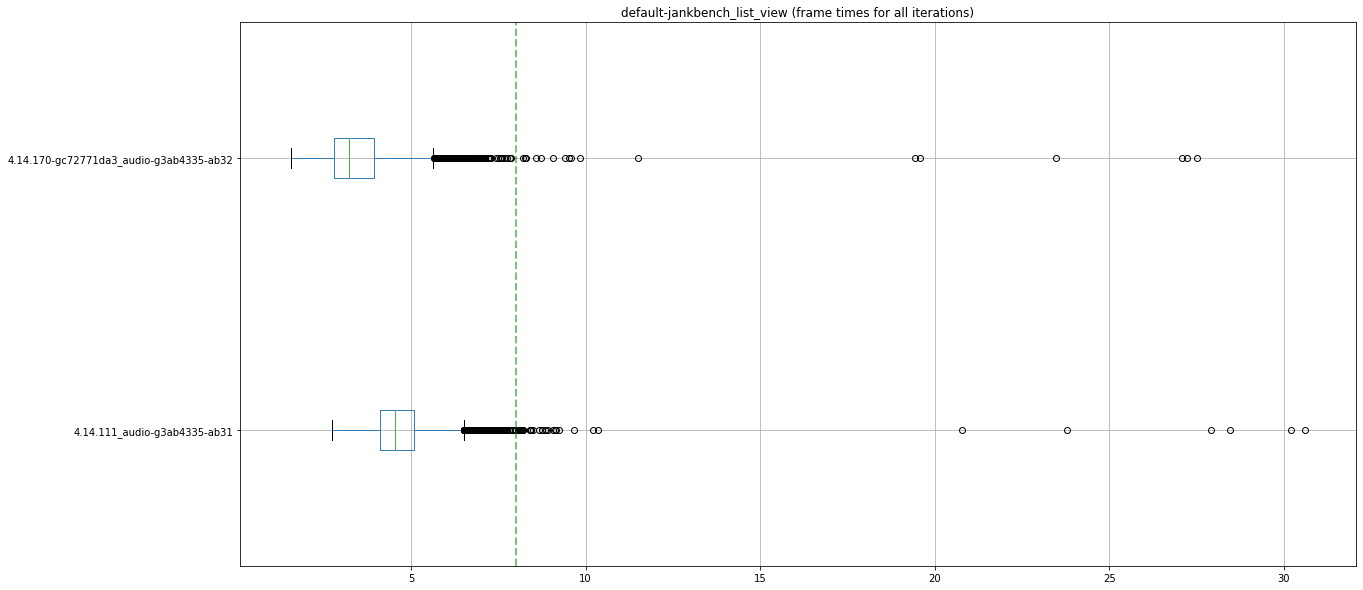

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4618.0,4.776866,4.685203,1.203624,2.726122,4.540234,7.692553,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,4618.0,3.508115,3.369581,1.245403,1.552157,3.220237,6.828499,27.517423


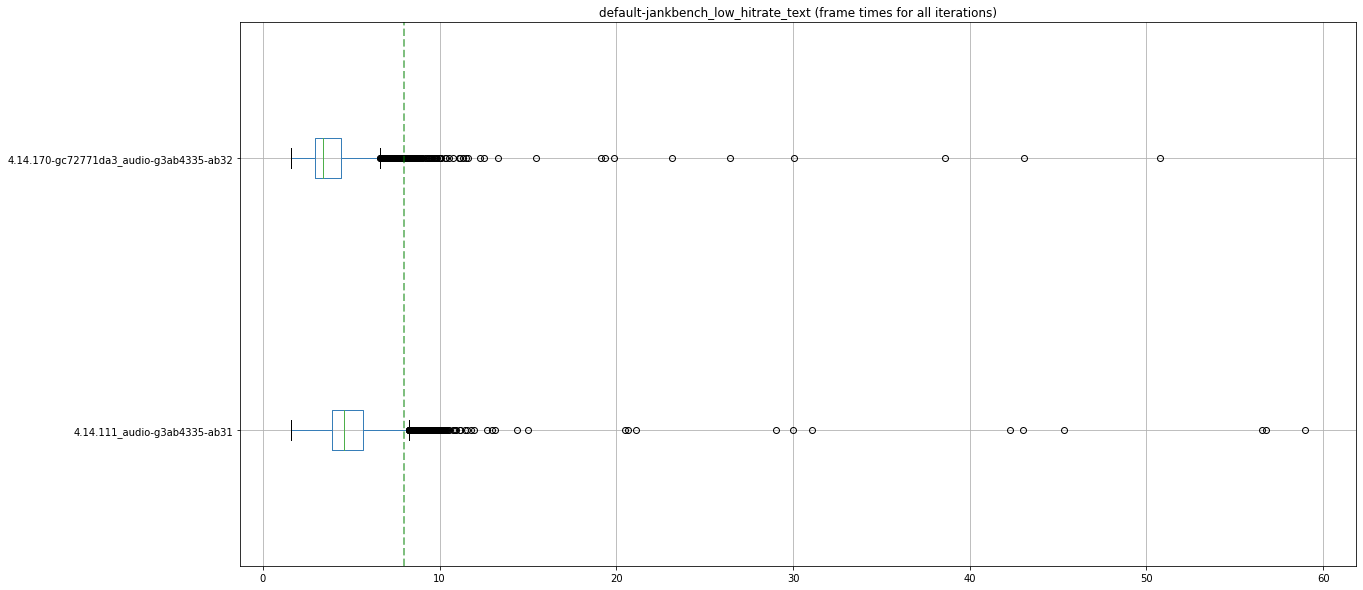

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4619.0,5.308539,4.981320,2.586923,1.609865,4.605182,10.141739,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,4619.0,4.050482,3.755365,2.071886,1.570313,3.374441,8.874638,50.738612


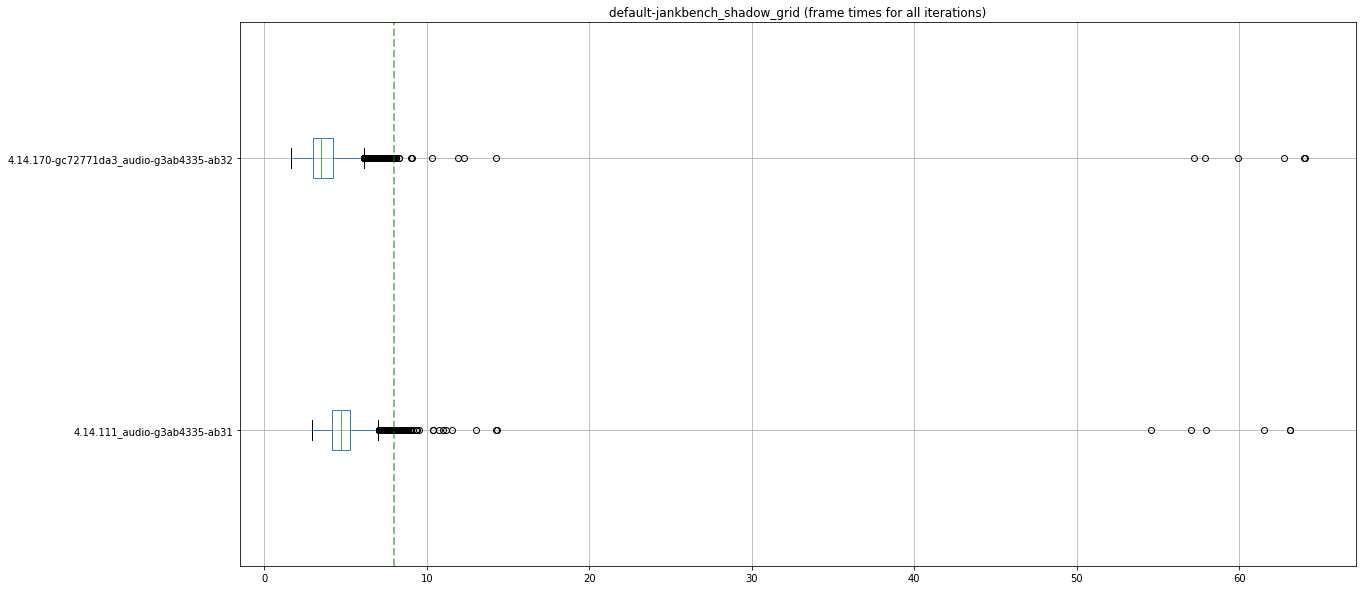

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,4622.0,4.935257,4.781114,2.230878,2.952212,4.741876,8.056605,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,4622.0,3.799410,3.618140,2.302113,1.621600,3.492878,7.114644,64.061386


In [17]:
# plot a pair of rendering times aggregated for all iterations, by workload
for workload_name in raw_df['id'].unique():
    tmp_df = raw_df[raw_df['id'] == workload_name]
    _jankbench_boxplot_frametimes(raw_df[raw_df['id'] == workload_name], threshold)

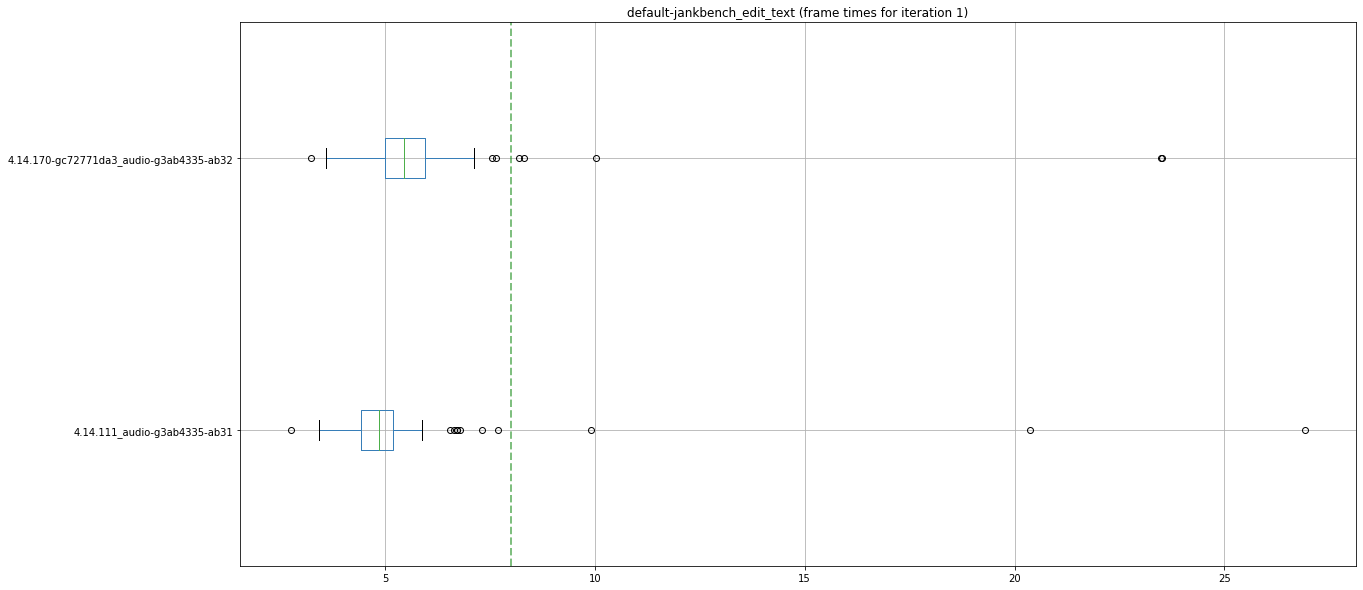

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.134157,4.928908,2.318813,2.755872,4.859580,14.930891,26.92421
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.768178,5.578591,2.218472,3.243944,5.449934,16.619324,23.51124


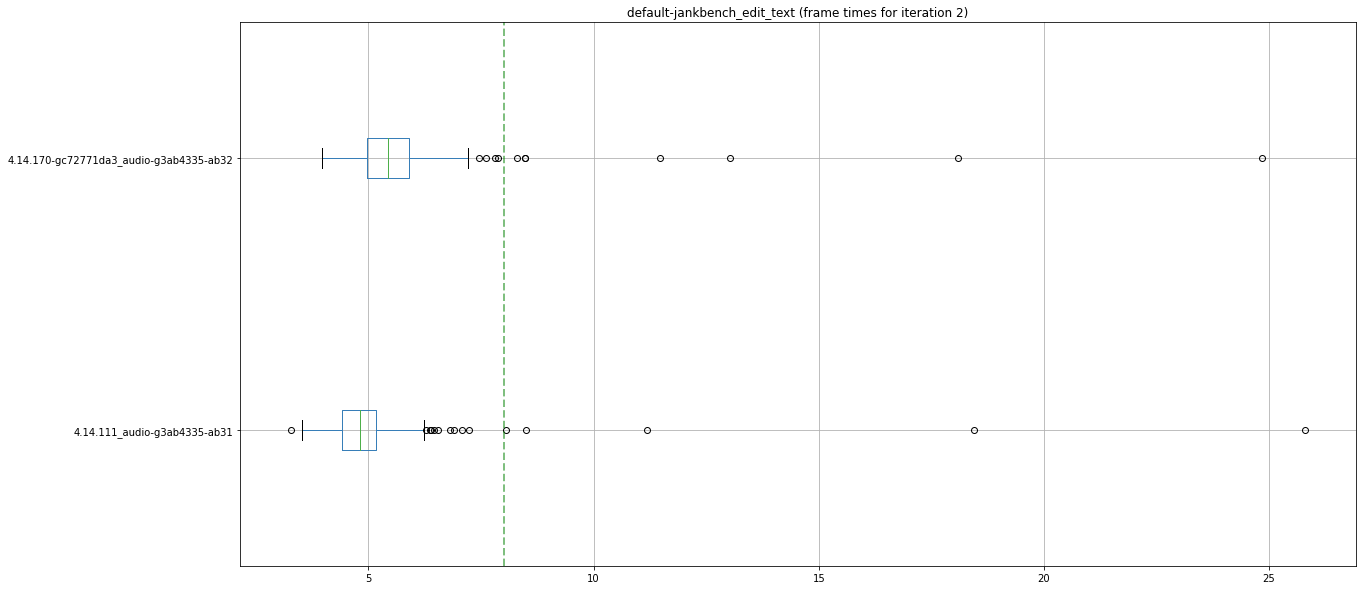

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.156334,4.955793,2.212472,3.271983,4.803898,14.676673,25.802094
4.14.170-gc72771da3_audio-g3ab4335-ab32,152.0,5.793222,5.599173,2.162354,3.968555,5.444025,15.511048,24.845349


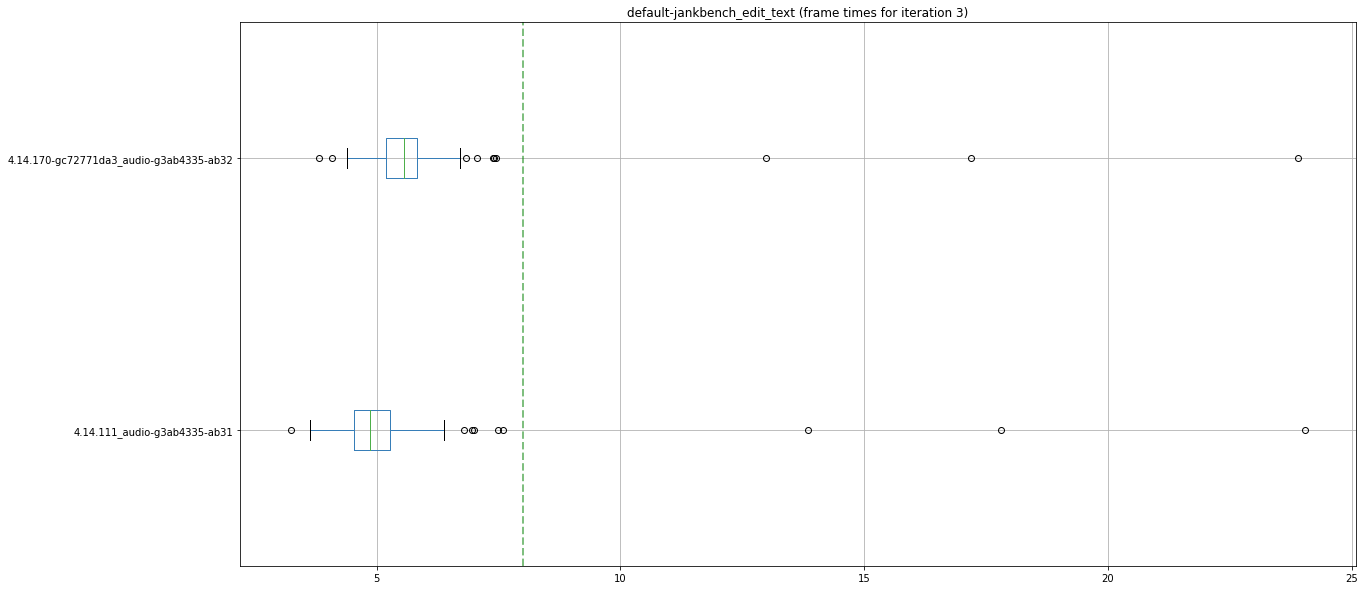

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,153.0,5.188264,5.003652,2.099094,3.239282,4.861180,15.742132,24.047949
4.14.170-gc72771da3_audio-g3ab4335-ab32,151.0,5.803944,5.654193,1.945235,3.824732,5.553381,15.085655,23.893524


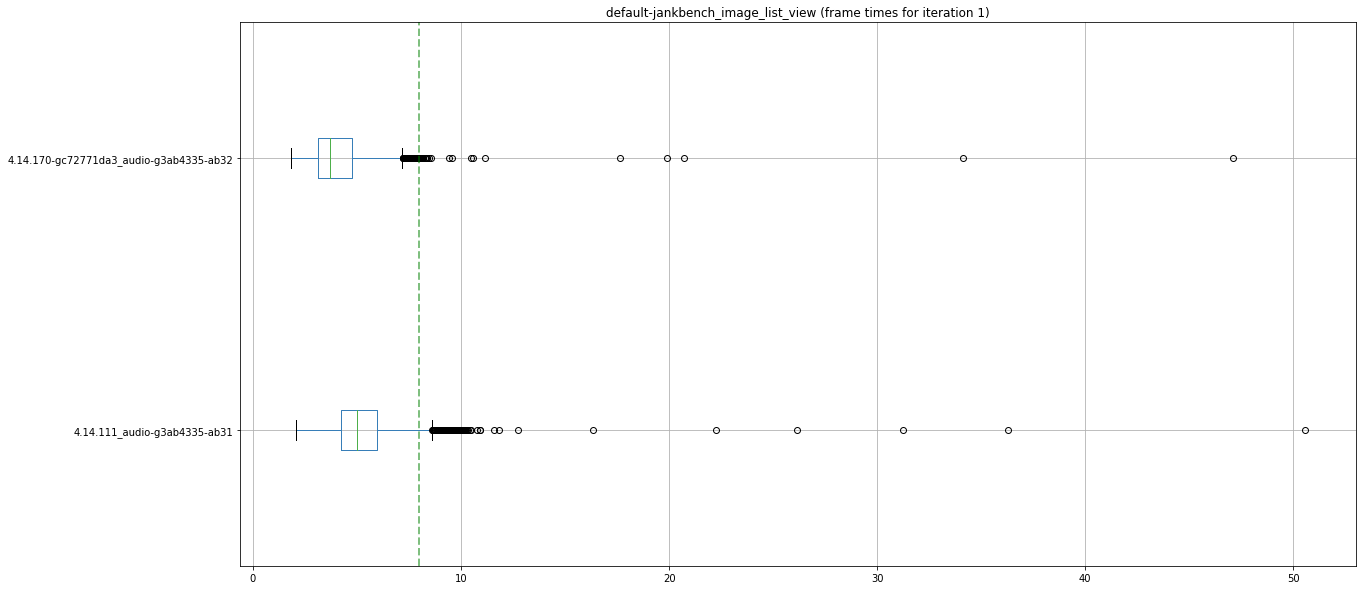

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1555.0,5.581046,5.300262,2.399445,2.076190,4.995110,10.259194,50.569232
4.14.170-gc72771da3_audio-g3ab4335-ab32,1552.0,4.280599,4.000879,2.127674,1.816144,3.699057,8.223343,47.088344


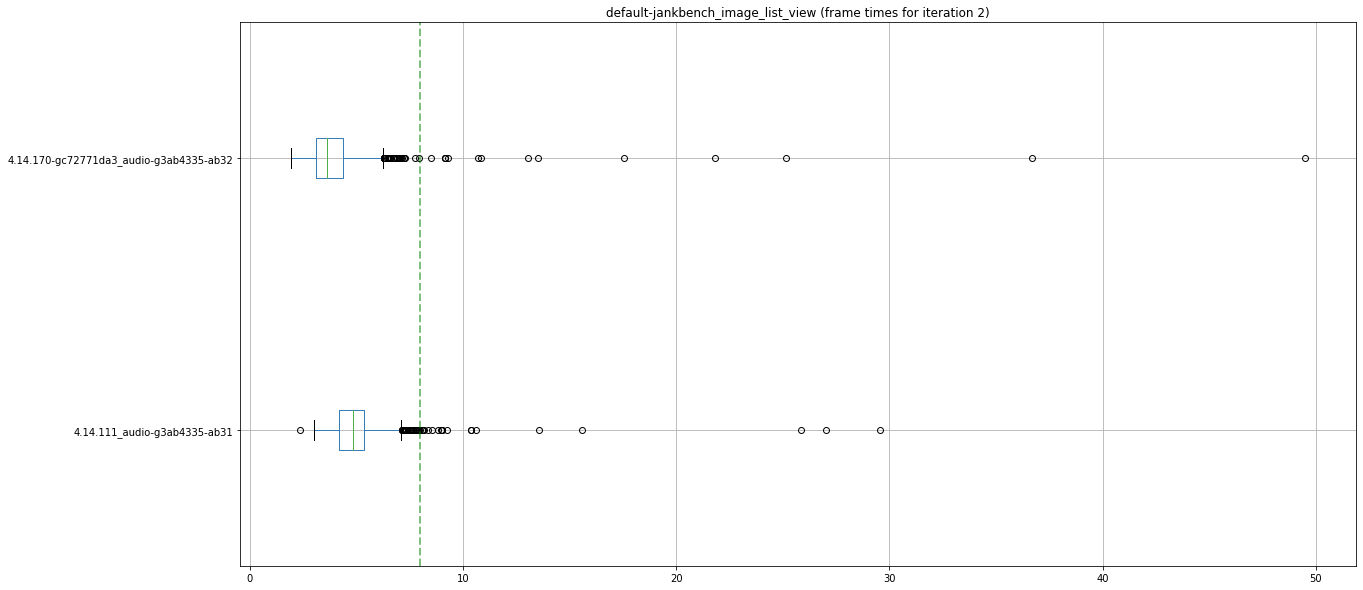

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1553.0,4.990405,4.869440,1.436331,2.369156,4.830083,8.143612,29.542067
4.14.170-gc72771da3_audio-g3ab4335-ab32,1553.0,3.911107,3.726691,1.951545,1.921995,3.619920,7.515231,49.497869


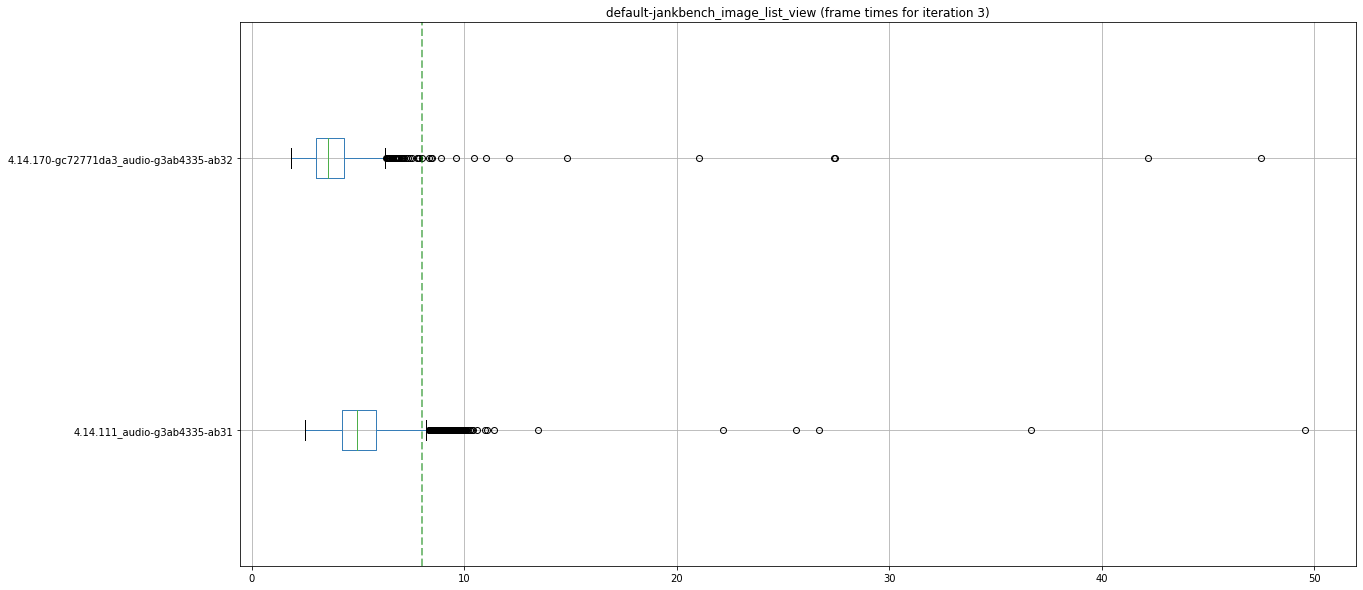

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1554.0,5.475445,5.211800,2.308716,2.500439,4.947966,10.093633,49.573037
4.14.170-gc72771da3_audio-g3ab4335-ab32,1554.0,3.911859,3.709346,2.080130,1.837316,3.602775,7.839526,47.473347


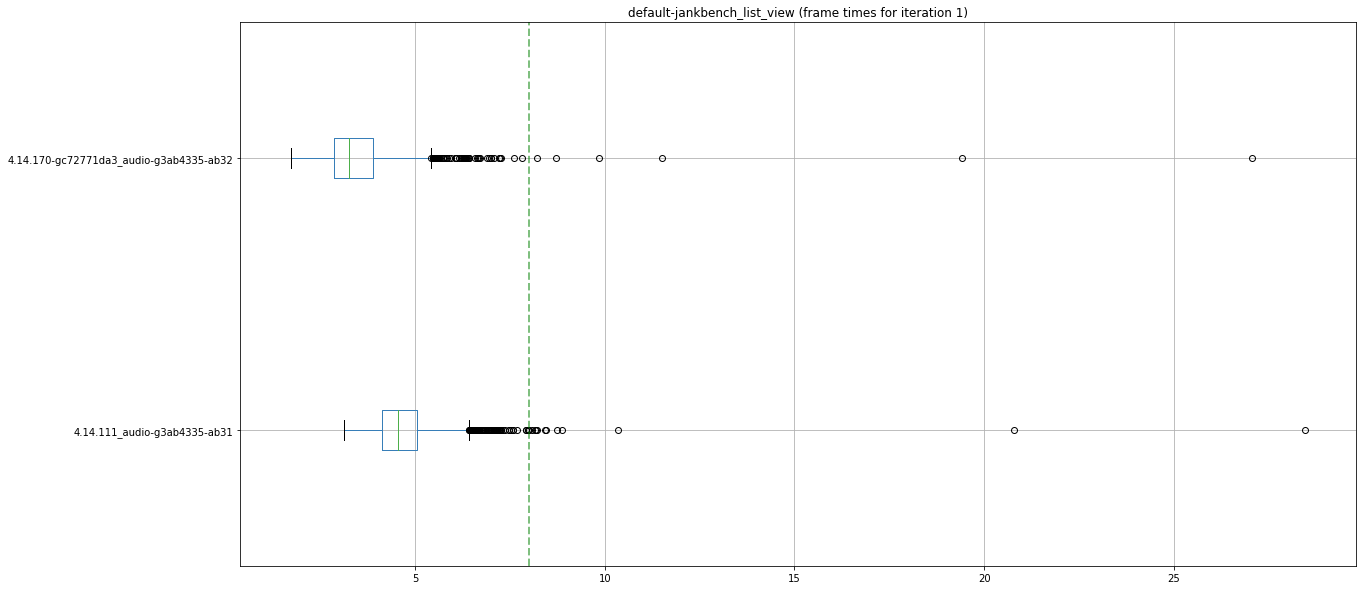

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,4.766864,4.680550,1.137408,3.130590,4.540704,7.833822,28.464746
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,3.528210,3.398287,1.211878,1.723055,3.264000,6.827057,27.068337


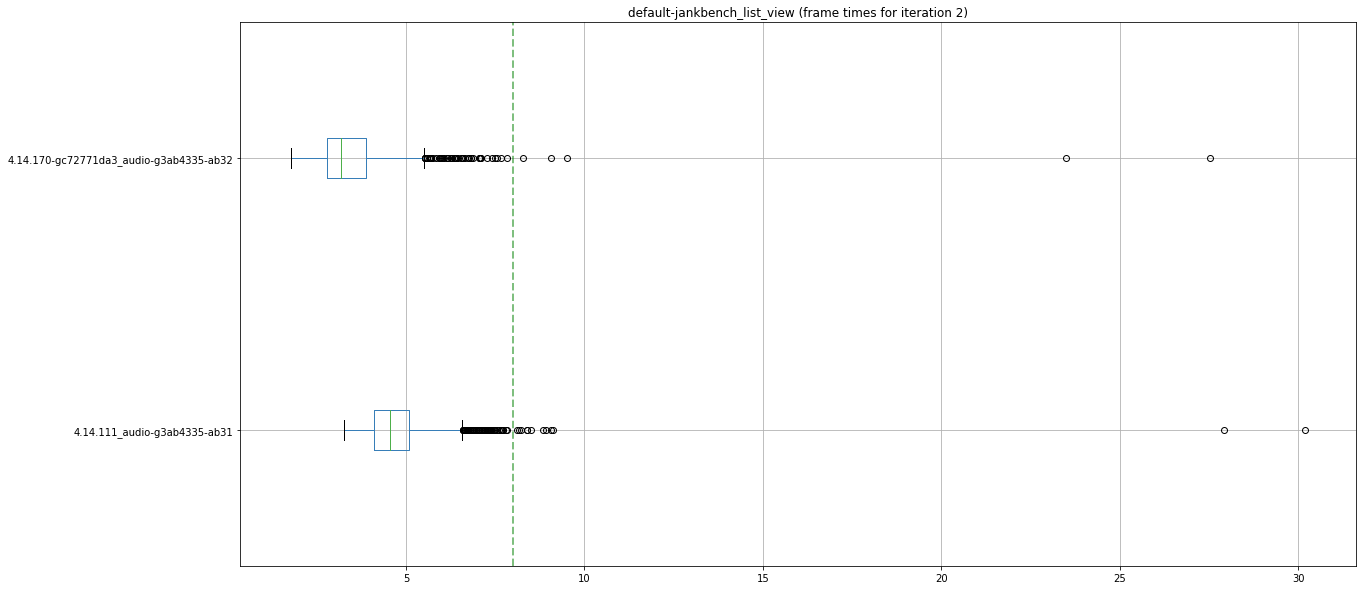

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.777654,4.682792,1.252175,3.261066,4.543900,7.704324,30.189177
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.486004,3.346952,1.269568,1.771138,3.179586,6.860087,27.517423


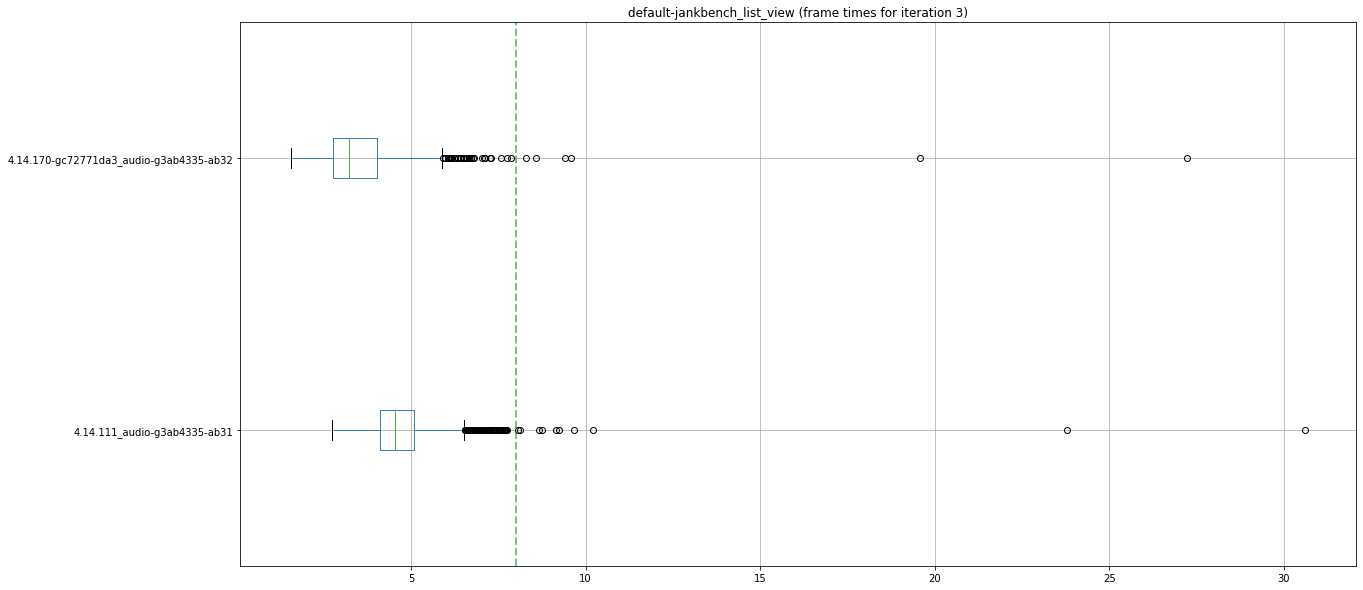

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1538.0,4.786084,4.692283,1.219042,2.726122,4.533288,7.663761,30.610042
4.14.170-gc72771da3_audio-g3ab4335-ab32,1538.0,3.510417,3.363903,1.254846,1.552157,3.221763,6.742260,27.213414


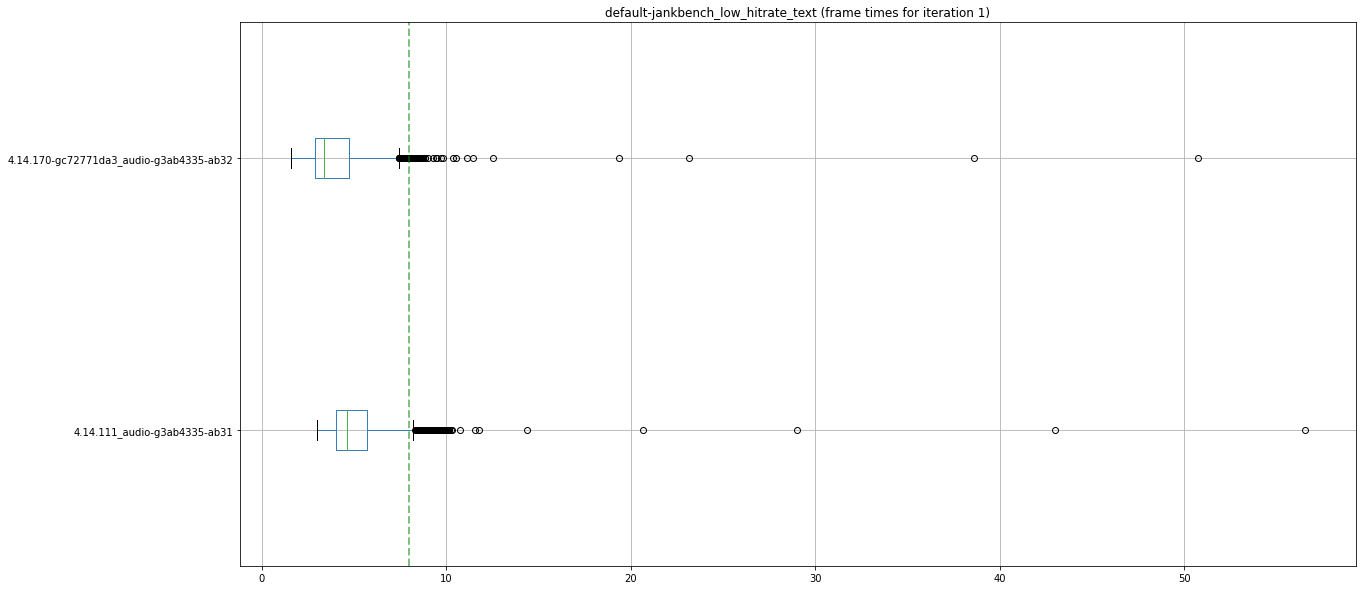

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.364815,5.045165,2.555254,3.014026,4.649350,10.082872,56.552763
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,4.202029,3.838683,2.414647,1.570313,3.403303,8.853334,50.738612


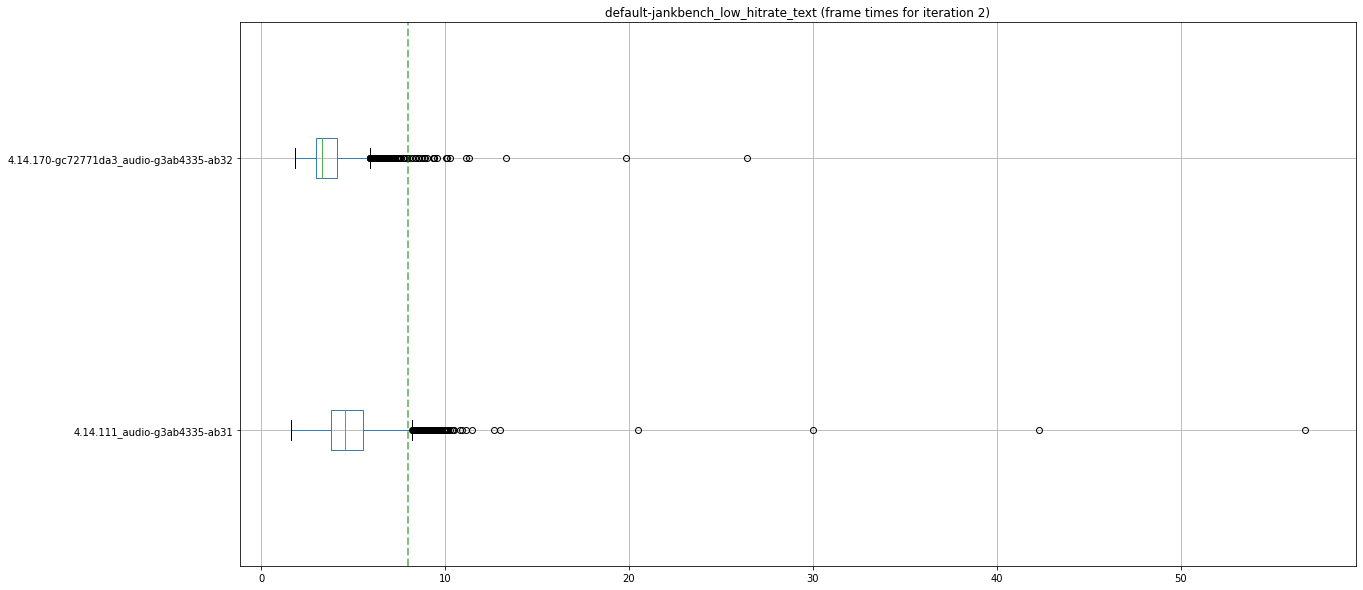

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,5.200935,4.863643,2.579922,1.609865,4.540425,10.156732,56.767492
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.765779,3.592029,1.435054,1.844110,3.313656,8.681754,26.435153


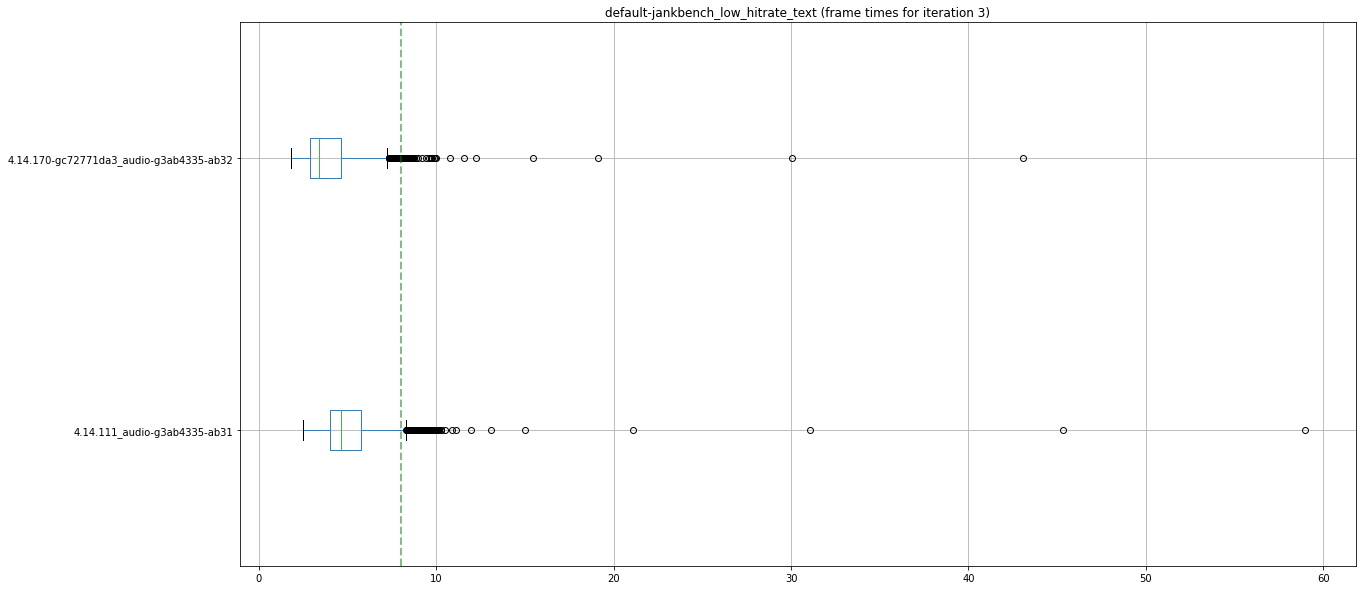

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1539.0,5.359900,5.037319,2.623473,2.502910,4.628194,10.098629,58.985066
4.14.170-gc72771da3_audio-g3ab4335-ab32,1539.0,4.183785,3.841043,2.207310,1.793326,3.400450,9.104537,43.093869


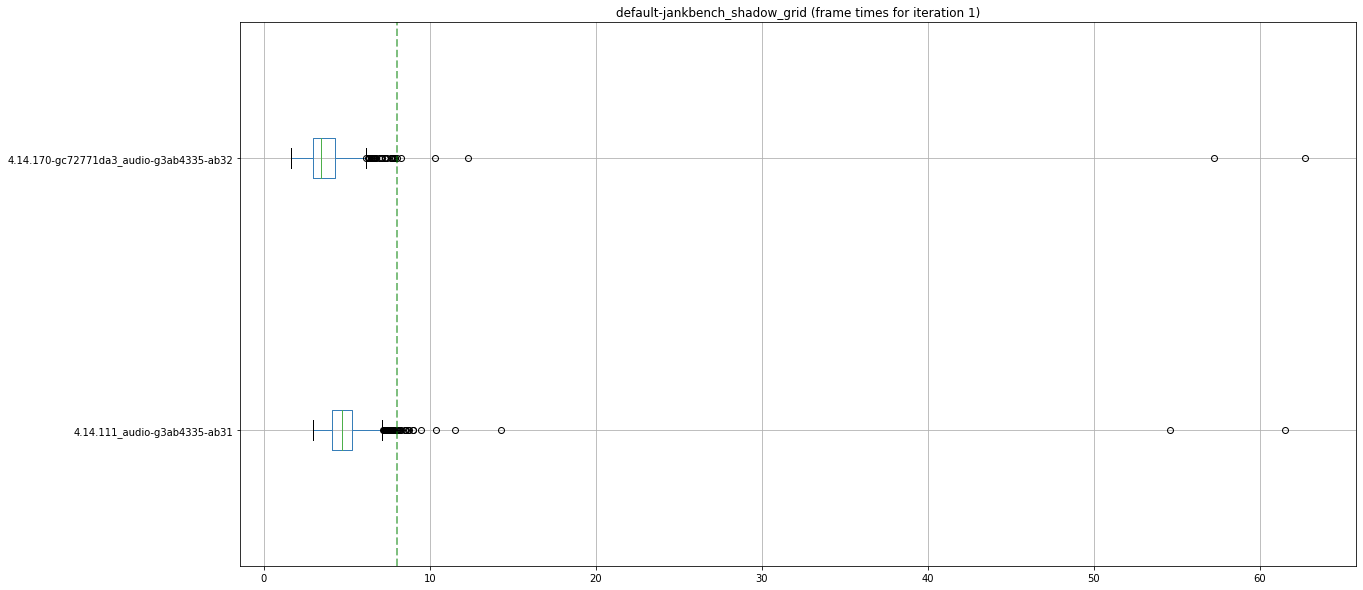

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1540.0,4.931087,4.774545,2.194790,2.987405,4.739452,8.145406,61.546247
4.14.170-gc72771da3_audio-g3ab4335-ab32,1540.0,3.793683,3.610495,2.276881,1.621600,3.466817,7.285168,62.746171


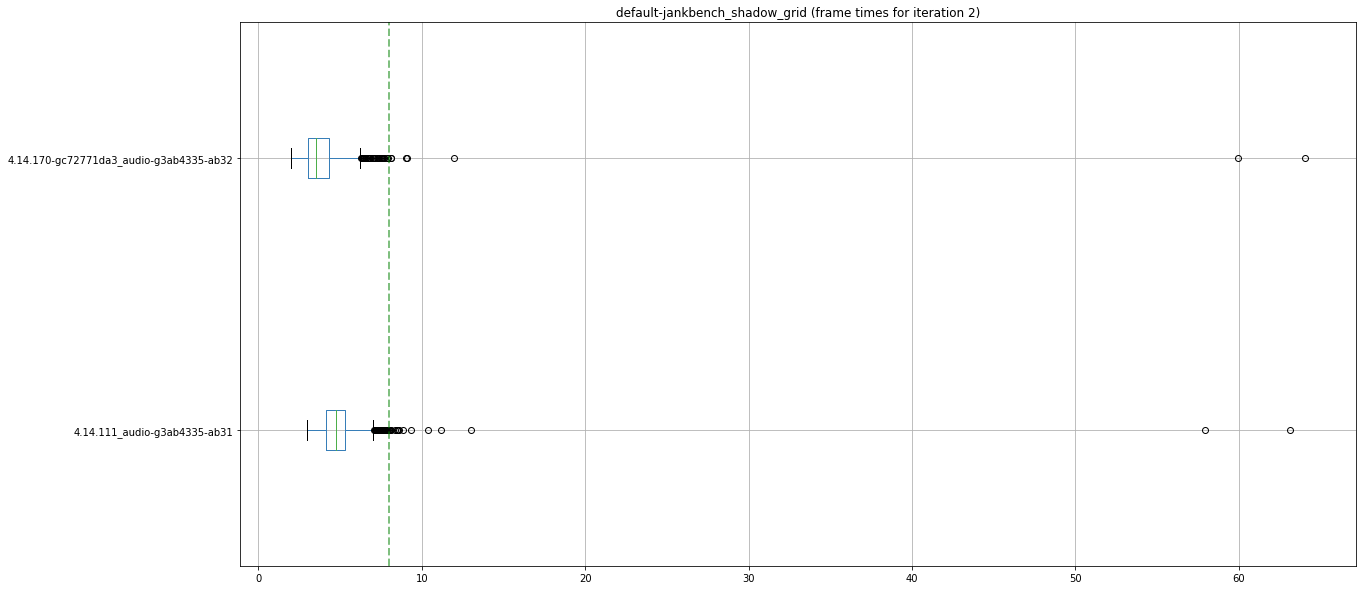

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.940513,4.786793,2.255955,2.952212,4.745021,7.977249,63.128868
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.844818,3.659118,2.342929,1.974045,3.511382,7.412238,64.061386


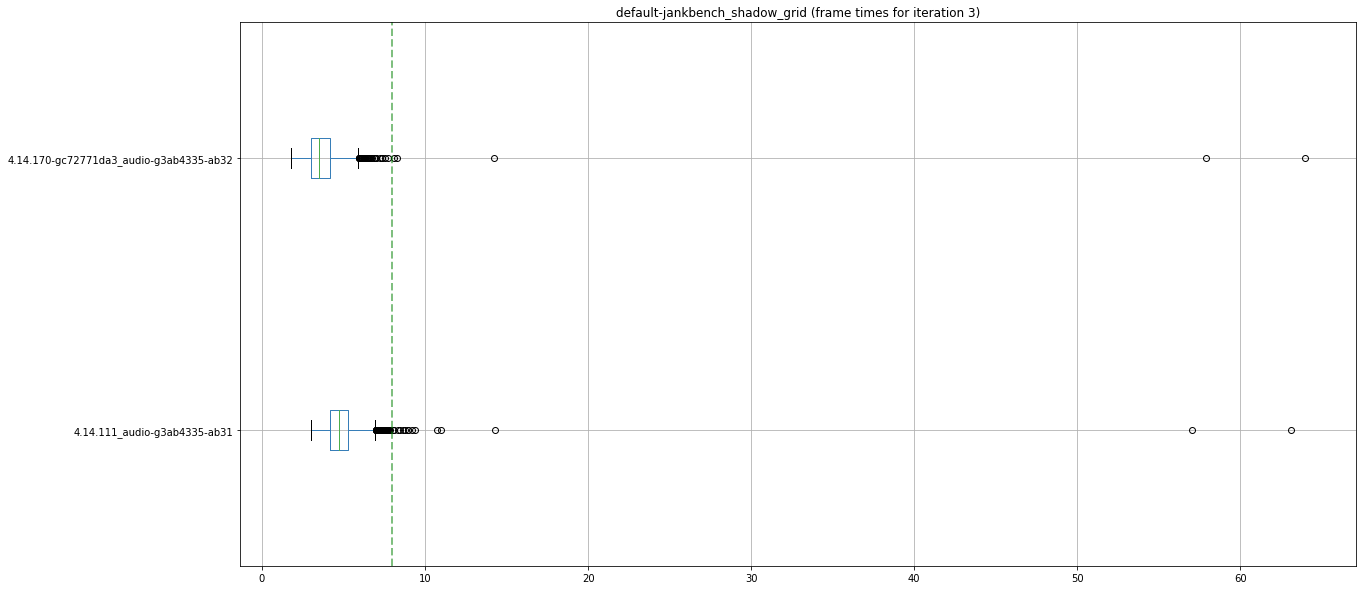

,count,mean,geomean,std,min,50%,99%,max
4.14.111_audio-g3ab4335-ab31,1541.0,4.934167,4.782006,2.242838,3.035733,4.736753,7.814312,63.113073
4.14.170-gc72771da3_audio-g3ab4335-ab32,1541.0,3.759559,3.585003,2.286703,1.764562,3.497899,6.647733,63.970617


In [18]:
# plot a pair of rendering times for each iteration, by workload
for workload_name in raw_df['id'].unique():
    tmp_df = raw_df[raw_df['id'] == workload_name]
    iterations = sorted(tmp_df['iteration'].unique())
    for it in iterations:
        _jankbench_boxplot_frametimes(raw_df[raw_df['id'] == workload_name], threshold, iteration=it)